# `CheMeleon` Foundation Finetuning

This notebook demonstrates how to use the `CheMeleon` foundation model with ChemProp to achieve accurate prediction on small datasets.
One can also use this functionality from the Command Line Interface by using `--from-foundation chemeleon`.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jacksonburns/chemeleon/blob/main/examples/finetuning_demo.ipynb)

In [1]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Tue_Oct_29_23:50:19_PDT_2024
Cuda compilation tools, release 12.6, V12.6.85
Build cuda_12.6.r12.6/compiler.35059454_0


In [2]:
!pip install rdkit
!pip install chemprop
!pip install matplotlib


In [4]:
import random
from random import sample, seed, shuffle
import numpy as np
import pandas as pd
import os
import six
from rdkit import rdBase
from rdkit import RDLogger

# Suppress RDKit warnings
rdBase.DisableLog('rdApp.*')
RDLogger.DisableLog('rdApp.*')

#utility functions : prepare the data
from model_fp_selection.lib.utils import prepare_df_morgan, prepare_df_rdkit, swap_identical_ligands, prepare_df_chemeleon, convert_to_float, prepare_df
from model_fp_selection.lib.utils import drop_duplicates, average_duplicates, calc_desc, get_ligands_dict

#utility functions : CV and results
from model_fp_selection.lib.utils import obtain_metrics, plot_cv_results
from model_fp_selection.lib.utils import df_split, get_indices_doi, get_indices_scaff, get_indices_chemeleon, get_indices_chemeleon_DOI, get_indices_chemeleon_scaff
from model_fp_selection.lib.utils import generate_scaffold, scaffold_to_smiles
from model_fp_selection.lib.utils import ligands_permutation, cross_validation, prepare_train_set, cross_validation_chemeleon


from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, Draw
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, median_absolute_error, PredictionErrorDisplay
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.preprocessing import MinMaxScaler

#Encoding categorical Data
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler

# Regressors
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

#Pipelines and other model constructions
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

# Visualization
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

#np.random.seed(42)
#seed(42)

#Specific to Scaffold Splitting
from rdkit.Chem.Scaffolds import MurckoScaffold
from collections import defaultdict
import pickle as pkl
import time
from tqdm import tqdm
#import seaborn as sns

from itertools import *

from model_fp_selection.lib.cross_val_both_models import cross_val_2_models

from model_fp_selection.chemeleon_fingerprint import CheMeleonFingerprint

from pathlib import Path

from lightning import pytorch as pl

from lightning.pytorch.callbacks import ModelCheckpoint
import pandas as pd

import torch.nn as torch_nn

from chemprop import data, models, featurizers, nn

import time

import lightning.pytorch as pl
from lightning.pytorch.callbacks import Callback
import torch

In [13]:
SEED = 42
pl.seed_everything(SEED, workers=True)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Seed set to 42


## Retrieving the `CheMeleon` Model

The `CheMeleon` model file is stored on Zenodo at [this link](https://zenodo.org/records/15460715).
Please cite the Zenodo if you use this model in published work.
You can manually download for your own use, or simply execute the below cell to programatically download it using Python:

In [5]:
from urllib.request import urlretrieve

urlretrieve(
    r"https://zenodo.org/records/15460715/files/chemeleon_mp.pt",
    "chemeleon_mp.pt",
)

('chemeleon_mp.pt', <http.client.HTTPMessage at 0x7fd53578ee90>)

## Initializing `CheMeleon`

`CheMeleon` uses the following classes for featurization, message passing, and aggregation:

In [14]:
featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer()
agg = nn.MeanAggregation()
chemeleon_mp = torch.load("chemeleon_mp.pt", weights_only=True)
mp = nn.BondMessagePassing(**chemeleon_mp['hyper_parameters'])
mp.load_state_dict(chemeleon_mp['state_dict'])

<All keys matched successfully>

If you have an existing ChemProp model, you can simply replace your `agg`, `featurizer`, and `mp` with these classes and you can immediately take advantage of `CheMeleon`!

## Standard ChemProp Preparation

The below code handles importing needed modules, setting up the data, and initializing the ChemProp model.
It's **mostly** the same as the `training` example provided in the ChemProp repository - for a more detailed breakdown, check that notebook.

The one important change is that we must set `input_dim=mp.output_dim` when we initialize our FFN.
This ensure that the dimension of the learned representation from `CheMeleon` matches the input size for the regressor.
Also important to note here is that to make the `CheMeleon` model useful you set up your own FFN to regress the target you care about - in this case lipophilicity.

In [15]:


pl._logger.setLevel("ERROR")  # suppress INFO and WARNING, only show ERROR+

chemprop_dir = Path.cwd().parent
num_workers = 0 # number of workers for dataloader. 0 means using main process for data loading
smiles_column = 'SMILES' # name of the column containing SMILES strings
target_columns = ['pIC50'] # list of names of the columns containing targets
df_input = pd.read_csv("./ruthenium_complexes_dataset_2.csv")

df_input = prepare_df(df_input)
df_input = average_duplicates(df_input,'Ligands_Dict', 'pIC50')


#df_input = df_input.sample(n=50)

df_input.reset_index(drop=True, inplace=True)

df_input['SMILES'] = df_input.L1 + '.' + df_input.L2 + '.' + df_input.L3
df_input['ID'] = df_input.index

loss_fn = torch_nn.L1Loss()

smis = df_input.loc[:, smiles_column].values
ys = df_input.loc[:, target_columns].values
all_data = [data.MoleculeDatapoint.from_smi(smi, y) for smi, y in zip(smis, ys)]
mols = [d.mol for d in all_data]  # RDkit Mol objects are use for structure based splits
#train_indices, val_indices, test_indices = data.make_split_indices(mols, "random", (0.8, 0.1, 0.1))  # unpack the tuple into three separate lists
#train_data, val_data, test_data = data.split_data_by_indices(
#    all_data, train_indices, val_indices, test_indices
#)


Length of training dataset after cleaning duplicates, before adding permutations : 718


Now we can take a look at the model, which we can see has the huge message passing setup from `CheMeleon`:

## Training

The remainder of this notebook again follows the typical training routine.
With the addition of `CheMeleon` your model may take longer to train but will (hopefully!) have better performance, particularly if the dataset you have is small!

In [16]:
indices = get_indices_chemeleon(df_input, 10, shuffle=True)

train length : 581 val length : 65 | test length : 72
train length : 581 val length : 65 | test length : 72
train length : 581 val length : 65 | test length : 72
train length : 581 val length : 65 | test length : 72
train length : 581 val length : 65 | test length : 72
train length : 581 val length : 65 | test length : 72
train length : 581 val length : 65 | test length : 72
train length : 581 val length : 65 | test length : 72
train length : 582 val length : 65 | test length : 71
train length : 582 val length : 65 | test length : 71


Dropping last batch of size 1 to avoid issues with batch normalization     (dataset size = 65, batch_size = 64)


/opt/python/lib/python3.13/site-packages/rich/live.py:260: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=71` in the `DataLoader` to improve performance.

CV iteration 0


/opt/python/lib/python3.13/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /home/onyxia/work/checkpoints exists and is not empty.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=71` in the `DataLoader` to improve performance.


/opt/python/lib/python3.13/site-packages/rich/live.py:260: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=71` in the `DataLoader` to improve performance.


/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=71` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.20363715291023254    │
│          test/r2          │    0.9053706526756287     │
│         test/rmse         │    0.3012518882751465     │
└───────────────────────────┴───────────────────────────┘

Dropping last batch of size 1 to avoid issues with batch normalization     (dataset size = 65, batch_size = 64)


/opt/python/lib/python3.13/site-packages/rich/live.py:260: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=71` in the `DataLoader` to improve performance.

CV iteration 1


/opt/python/lib/python3.13/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /home/onyxia/work/checkpoints exists and is not empty.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=71` in the `DataLoader` to improve performance.


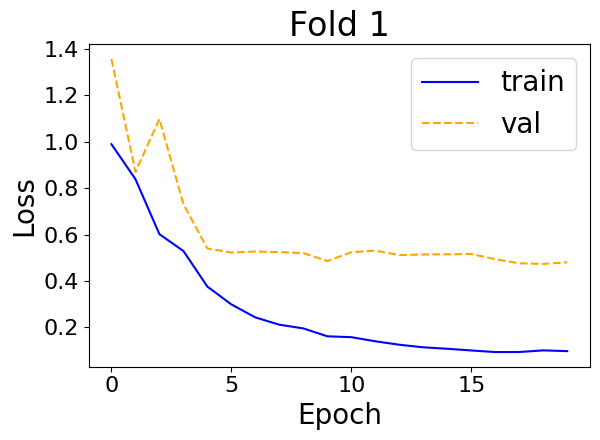

/opt/python/lib/python3.13/site-packages/rich/live.py:260: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=71` in the `DataLoader` to improve performance.


/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=71` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.15570569038391113    │
│          test/r2          │    0.9430701732635498     │
│         test/rmse         │    0.21026897430419922    │
└───────────────────────────┴───────────────────────────┘

Dropping last batch of size 1 to avoid issues with batch normalization     (dataset size = 65, batch_size = 64)


/opt/python/lib/python3.13/site-packages/rich/live.py:260: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=71` in the `DataLoader` to improve performance.

CV iteration 2


/opt/python/lib/python3.13/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /home/onyxia/work/checkpoints exists and is not empty.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=71` in the `DataLoader` to improve performance.


/opt/python/lib/python3.13/site-packages/rich/live.py:260: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=71` in the `DataLoader` to improve performance.


/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=71` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.19212232530117035    │
│          test/r2          │    0.9112432599067688     │
│         test/rmse         │    0.26426613330841064    │
└───────────────────────────┴───────────────────────────┘

Dropping last batch of size 1 to avoid issues with batch normalization     (dataset size = 65, batch_size = 64)


/opt/python/lib/python3.13/site-packages/rich/live.py:260: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=71` in the `DataLoader` to improve performance.

CV iteration 3


/opt/python/lib/python3.13/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /home/onyxia/work/checkpoints exists and is not empty.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=71` in the `DataLoader` to improve performance.


/opt/python/lib/python3.13/site-packages/rich/live.py:260: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=71` in the `DataLoader` to improve performance.


/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=71` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.1403181403875351     │
│          test/r2          │    0.9380808472633362     │
│         test/rmse         │    0.19804798066616058    │
└───────────────────────────┴───────────────────────────┘

Dropping last batch of size 1 to avoid issues with batch normalization     (dataset size = 65, batch_size = 64)


/opt/python/lib/python3.13/site-packages/rich/live.py:260: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=71` in the `DataLoader` to improve performance.

CV iteration 4


/opt/python/lib/python3.13/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /home/onyxia/work/checkpoints exists and is not empty.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=71` in the `DataLoader` to improve performance.


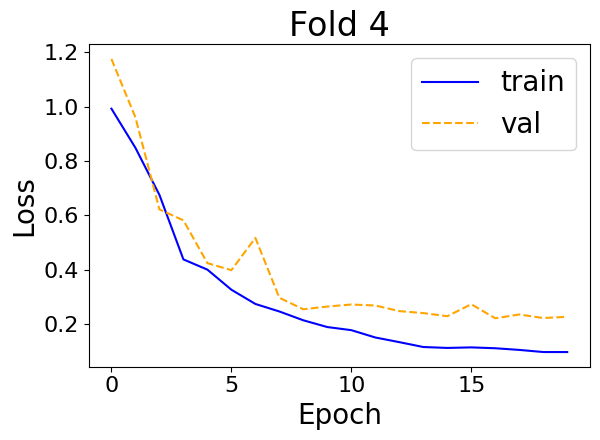

/opt/python/lib/python3.13/site-packages/rich/live.py:260: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=71` in the `DataLoader` to improve performance.


/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=71` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.1510608196258545     │
│          test/r2          │     0.918763279914856     │
│         test/rmse         │    0.21602338552474976    │
└───────────────────────────┴───────────────────────────┘

Dropping last batch of size 1 to avoid issues with batch normalization     (dataset size = 65, batch_size = 64)


/opt/python/lib/python3.13/site-packages/rich/live.py:260: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=71` in the `DataLoader` to improve performance.

CV iteration 5


/opt/python/lib/python3.13/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /home/onyxia/work/checkpoints exists and is not empty.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=71` in the `DataLoader` to improve performance.


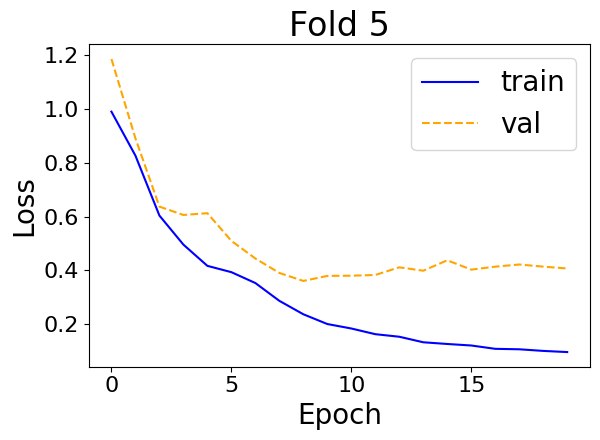

/opt/python/lib/python3.13/site-packages/rich/live.py:260: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=71` in the `DataLoader` to improve performance.


/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=71` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.14886900782585144    │
│          test/r2          │    0.9539796710014343     │
│         test/rmse         │    0.1895071417093277     │
└───────────────────────────┴───────────────────────────┘

Dropping last batch of size 1 to avoid issues with batch normalization     (dataset size = 65, batch_size = 64)


/opt/python/lib/python3.13/site-packages/rich/live.py:260: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=71` in the `DataLoader` to improve performance.

CV iteration 6


/opt/python/lib/python3.13/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /home/onyxia/work/checkpoints exists and is not empty.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=71` in the `DataLoader` to improve performance.


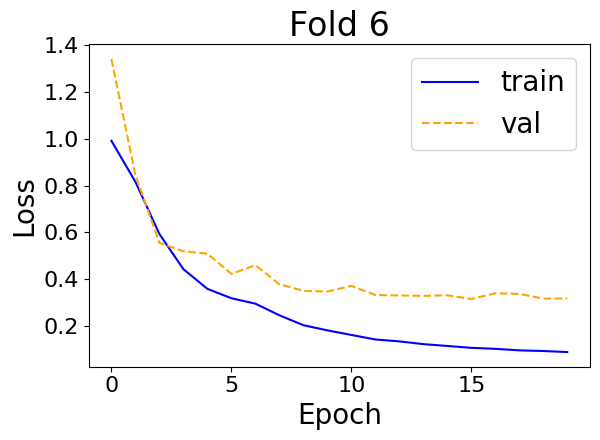

/opt/python/lib/python3.13/site-packages/rich/live.py:260: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=71` in the `DataLoader` to improve performance.


/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=71` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.17581412196159363    │
│          test/r2          │    0.8999751210212708     │
│         test/rmse         │    0.2230362892150879     │
└───────────────────────────┴───────────────────────────┘

Dropping last batch of size 1 to avoid issues with batch normalization     (dataset size = 65, batch_size = 64)


/opt/python/lib/python3.13/site-packages/rich/live.py:260: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=71` in the `DataLoader` to improve performance.

CV iteration 7


/opt/python/lib/python3.13/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /home/onyxia/work/checkpoints exists and is not empty.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=71` in the `DataLoader` to improve performance.


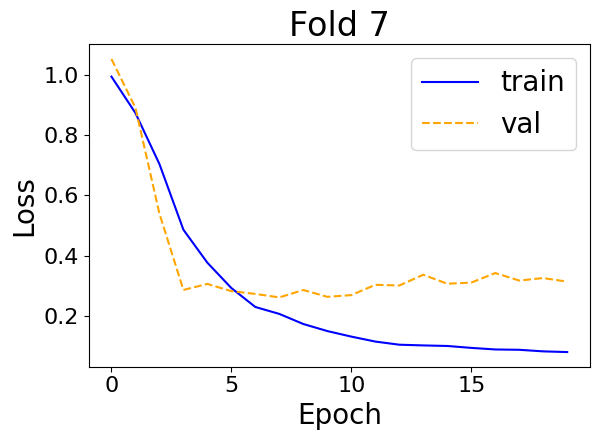

/opt/python/lib/python3.13/site-packages/rich/live.py:260: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=71` in the `DataLoader` to improve performance.


/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=71` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.20856435596942902    │
│          test/r2          │    0.8455168604850769     │
│         test/rmse         │    0.29356369376182556    │
└───────────────────────────┴───────────────────────────┘

Dropping last batch of size 1 to avoid issues with batch normalization     (dataset size = 65, batch_size = 64)


/opt/python/lib/python3.13/site-packages/rich/live.py:260: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=71` in the `DataLoader` to improve performance.

CV iteration 8


/opt/python/lib/python3.13/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /home/onyxia/work/checkpoints exists and is not empty.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=71` in the `DataLoader` to improve performance.


/opt/python/lib/python3.13/site-packages/rich/live.py:260: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=71` in the `DataLoader` to improve performance.


/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=71` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.3514896333217621     │
│          test/r2          │    0.6267640590667725     │
│         test/rmse         │    0.49329784512519836    │
└───────────────────────────┴───────────────────────────┘

Dropping last batch of size 1 to avoid issues with batch normalization     (dataset size = 65, batch_size = 64)


/opt/python/lib/python3.13/site-packages/rich/live.py:260: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=71` in the `DataLoader` to improve performance.

CV iteration 9


/opt/python/lib/python3.13/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /home/onyxia/work/checkpoints exists and is not empty.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=71` in the `DataLoader` to improve performance.


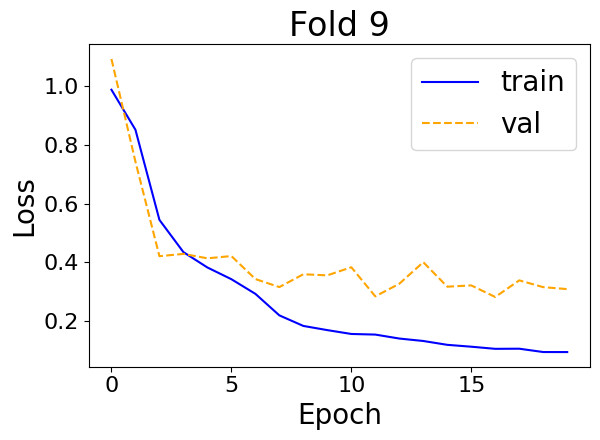

/opt/python/lib/python3.13/site-packages/rich/live.py:260: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=71` in the `DataLoader` to improve performance.


/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=71` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.16901691257953644    │
│          test/r2          │    0.9010381102561951     │
│         test/rmse         │    0.2516273260116577     │
└───────────────────────────┴───────────────────────────┘

Total training time: 823.34 seconds (13.72 minutes)
{'MAE': 0.3374107323252958, 'RMSE': np.float64(0.46422912395314536), 'Ratio': np.float64(1.3758576105563374), 'R² Score': 0.6902131979770242}


In [18]:
y_data, y_predictions = cross_validation_chemeleon(all_data, indices)

In [10]:
plot_cv_results(y_data, y_predictions)

### Trying witout pretraining of the model (not loading state_dict at each iteration)

In [ ]:
class LossHistory(pl.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.history = []   # initialize here

    def on_train_epoch_end(self, trainer, pl_module):
        # Extract losses if available
        train_loss = trainer.callback_metrics.get("train_loss")
        val_loss = trainer.callback_metrics.get("val_loss")

        entry = {
            "epoch": trainer.current_epoch,
            "train_loss": float(train_loss) if train_loss is not None else None,
            "val_loss": float(val_loss) if val_loss is not None else None,
        }
        self.history.append(entry)

loss_history = LossHistory()

checkpointing = ModelCheckpoint(
    "checkpoints",  # Directory where model checkpoints will be saved
    "best-{epoch}-{val_loss:.2f}",  # Filename format for checkpoints, including epoch and validation loss
    "val_loss",  # Metric used to select the best checkpoint (based on validation loss)
    mode="min",  # Save the checkpoint with the lowest validation loss (minimization objective)
    save_last=True,  # Always save the most recent checkpoint, even if it's not the best
    )

def cross_validation_chemeleon_no_pre_training(all_data, indices, num_workers=0):
    y_data= []
    y_predictions = []

    all_metrics = []

    all_loss_histories = []  # collect across folds

    train_CV, val_CV, test_CV = indices

    start_time = time.time()

    for i in range(len(train_CV)):
        print("CV iteration", i)

        loss_history = LossHistory()

        featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer()
        agg = nn.MeanAggregation()
        chemeleon_mp = torch.load("chemeleon_mp.pt", weights_only=True)
        mp = nn.BondMessagePassing(**chemeleon_mp['hyper_parameters'])
        #mp.load_state_dict(chemeleon_mp['state_dict'])

        train_indices, val_indices, test_indices = [train_CV[i]], [val_CV[i]], [test_CV[i]]  # unpack the tuple into three separate lists
        train_data, val_data, test_data = data.split_data_by_indices(
          all_data, train_indices, val_indices, test_indices
        )
        train_dset = data.MoleculeDataset(train_data[0], featurizer)
        scaler = train_dset.normalize_targets()
        val_dset = data.MoleculeDataset(val_data[0], featurizer)
        val_dset.normalize_targets(scaler)
        test_dset = data.MoleculeDataset(test_data[0], featurizer)
        #test_dset.normalize_targets(scaler) this dramatically lowers R2
        train_loader = data.build_dataloader(train_dset, num_workers=num_workers)
        val_loader = data.build_dataloader(val_dset, num_workers=num_workers, shuffle=False)
        test_loader = data.build_dataloader(test_dset, num_workers=num_workers, shuffle=False)
        output_transform = nn.UnscaleTransform.from_standard_scaler(scaler)

        ffn = nn.RegressionFFN(output_transform=output_transform,
        input_dim=mp.output_dim,
        n_layers=3,
        hidden_dim = 400,
        dropout=0.1)

        metric_list = [nn.metrics.RMSE(), nn.metrics.MAE(), nn.metrics.R2Score()]
        mpnn = models.MPNN(mp, agg, ffn, batch_norm=False, metrics=metric_list)

        trainer = pl.Trainer(
        logger=False,               # disable TensorBoard/W&B logging
        enable_model_summary=False, # disables model architecture printout
        enable_checkpointing=True, # Use `True` if you want to save model checkpoints. The checkpoints will be saved in the `checkpoints` folder.
        enable_progress_bar=True,
        log_every_n_steps=0,
        accelerator="gpu",
        devices=1,
        max_epochs=20, # number of epochs to train for
        callbacks=[checkpointing, loss_history], # Use the configured checkpoint callback
        )

        trainer.fit(mpnn, train_loader, val_loader, weights_only=False)   # Fit model to data

        # Ploting loss curve for each CV iteration

        df_losses = pd.DataFrame(loss_history.history)
        df_losses["fold"] = i
        all_loss_histories.append(df_losses)

        fold_df = df_losses.sort_values("epoch")

        plt.figure()

        plt.plot(fold_df["epoch"], fold_df["train_loss"], label="train", color="blue")
        plt.plot(fold_df["epoch"], fold_df["val_loss"], linestyle="--", label="val", color="orange")

        plt.title(f"Fold {i}")
        plt.ylabel("Loss")
        plt.legend()

        plt.xlabel("Epoch")
        plt.tight_layout()
        plt.show()

        ###

        test_preds = trainer.predict(mpnn, test_loader, weights_only=False)
        test_preds = torch.cat([tensor for tensor in test_preds]) # Predict values

        for i in range(len(test_preds)):
            y_predictions.append(float(test_preds[i][0]))
            y_data.append(test_data[0][i].y[0]) # Update lists

        results = trainer.test(dataloaders=test_loader, weights_only=False)
        all_metrics.append(results)

    end_time = time.time()

    total_time = end_time - start_time
    print(f"Total training time: {total_time:.2f} seconds ({total_time/60:.2f} minutes)")

    y_data = np.array(y_data)
    y_predictions = np.array(y_predictions)

    metrics = obtain_metrics(y_data, y_predictions)
    print(metrics)

    return y_data, y_predictions

In [ ]:
indices2 = get_indices_chemeleon(df_input, 10, shuffle=True)

train length : 581 val length : 65 | test length : 72
train length : 581 val length : 65 | test length : 72
train length : 581 val length : 65 | test length : 72
train length : 581 val length : 65 | test length : 72
train length : 581 val length : 65 | test length : 72
train length : 581 val length : 65 | test length : 72
train length : 581 val length : 65 | test length : 72
train length : 581 val length : 65 | test length : 72
train length : 582 val length : 65 | test length : 71
train length : 582 val length : 65 | test length : 71


Output()

CV iteration 0


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /content/checkpoints exists and is not empty.


Output()

Output()

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.6008754968643188     │
│          test/r2          │    0.35367774963378906    │
│         test/rmse         │    0.7873028516769409     │
└───────────────────────────┴───────────────────────────┘

Output()

CV iteration 1


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /content/checkpoints exists and is not empty.


Output()

Output()

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.3988908529281616     │
│          test/r2          │    0.6560381650924683     │
│         test/rmse         │    0.5168449878692627     │
└───────────────────────────┴───────────────────────────┘

Output()

CV iteration 2


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /content/checkpoints exists and is not empty.


Output()

Output()

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.4225648045539856     │
│          test/r2          │    0.6484853029251099     │
│         test/rmse         │    0.5259113907814026     │
└───────────────────────────┴───────────────────────────┘

Output()

CV iteration 3


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /content/checkpoints exists and is not empty.


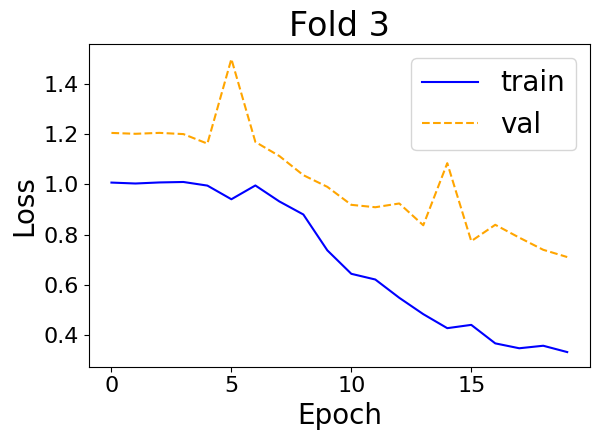

Output()

Output()

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.32993072271347046    │
│          test/r2          │     0.726061224937439     │
│         test/rmse         │    0.41656848788261414    │
└───────────────────────────┴───────────────────────────┘

Output()

CV iteration 4


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /content/checkpoints exists and is not empty.


Output()

Output()

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.35809725522994995    │
│          test/r2          │     0.639685869216919     │
│         test/rmse         │    0.4549509584903717     │
└───────────────────────────┴───────────────────────────┘

Output()

CV iteration 5


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /content/checkpoints exists and is not empty.


Output()

Output()

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.3909617066383362     │
│          test/r2          │    0.6501586437225342     │
│         test/rmse         │    0.5224995017051697     │
└───────────────────────────┴───────────────────────────┘

Output()

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /content/checkpoints exists and is not empty.


Output()

Output()

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.39176511764526367    │
│          test/r2          │    0.48435479402542114    │
│         test/rmse         │    0.5064029097557068     │
└───────────────────────────┴───────────────────────────┘

Output()

CV iteration 7


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /content/checkpoints exists and is not empty.


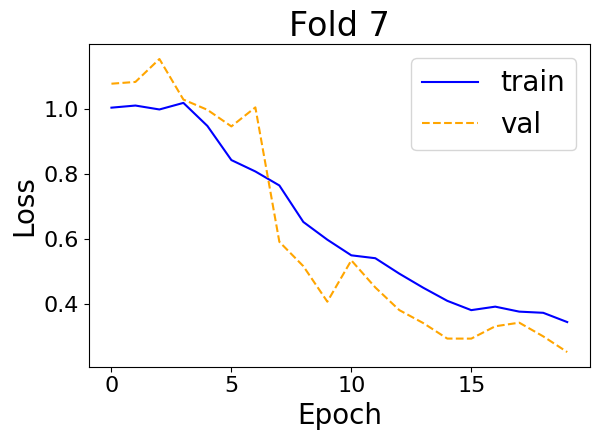

Output()

Output()

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.5321431756019592     │
│          test/r2          │    0.01699662208557129    │
│         test/rmse         │     0.740526556968689     │
└───────────────────────────┴───────────────────────────┘

Output()

CV iteration 8


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /content/checkpoints exists and is not empty.


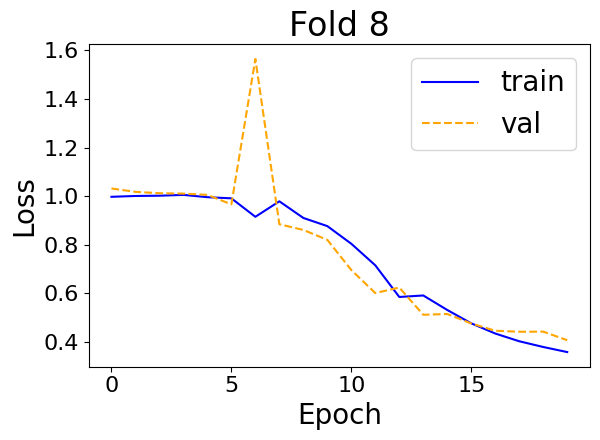

Output()

Output()

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.37908312678337097    │
│          test/r2          │     0.635616660118103     │
│         test/rmse         │    0.48741450905799866    │
└───────────────────────────┴───────────────────────────┘

Output()

CV iteration 9


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /content/checkpoints exists and is not empty.


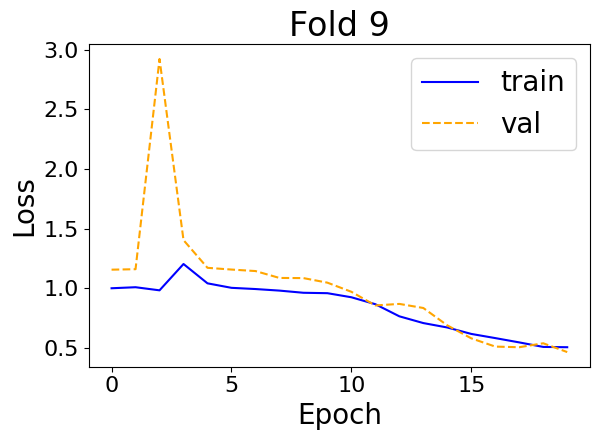

Output()

Output()

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.3707521855831146     │
│          test/r2          │     0.621974527835846     │
│         test/rmse         │    0.49179524183273315    │
└───────────────────────────┴───────────────────────────┘

Total training time: 951.17 seconds (15.85 minutes)
{'MAE': 0.4606292390131165, 'RMSE': np.float64(0.6070382153185689), 'Ratio': np.float64(1.3178455988141982), 'R² Score': 0.4702997105086081}


In [ ]:
y_data2, y_predictions2 = cross_validation_chemeleon_no_pre_training(all_data, indices2)

In [ ]:
plot_cv_results(y_data2,y_predictions2)

In [ ]:
i = 0
outlier = 0
for i in range(len(y_predictions2)):
  if y_predictions2[i] > 9:
    outlier = i
y_predictions2 = np.delete(y_predictions2, outlier)
y_data2 = np.delete(y_data2, outlier)
obtain_metrics(y_data2, y_predictions2)

{'MAE': 0.4610621351393798,
 'RMSE': np.float64(0.607435472330551),
 'Ratio': np.float64(1.3174698723566234),
 'R² Score': 0.4703373855003108}

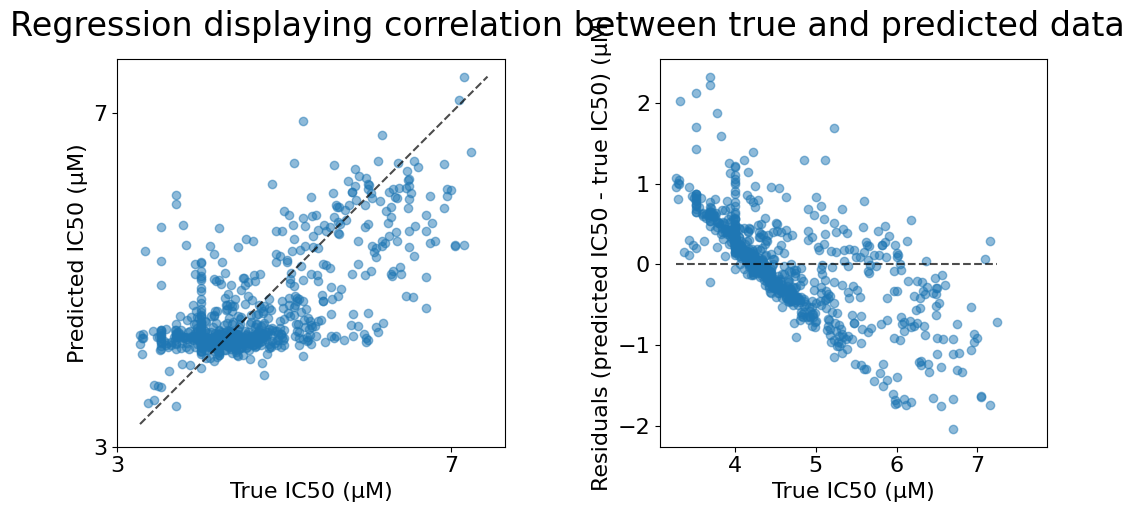

In [ ]:
plot_cv_results(y_data2, y_predictions2)

## HeLa cells

In [13]:
df_input_hela = df_input[df_input['Cells'] == 'HeLa']
df_input_hela = df_input_hela.reset_index()

In [14]:
smis_hela = df_input_hela.loc[:, smiles_column].values
ys_hela = df_input_hela.loc[:, target_columns].values
all_data_hela = [data.MoleculeDatapoint.from_smi(smi, y) for smi, y in zip(smis_hela, ys_hela)]
mols_hela = [d.mol for d in all_data_hela]

In [15]:
indices_hela = get_indices_chemeleon(df_input_hela, CV=10, shuffle=True)

train length : 147 val length : 17 | test length : 19
train length : 147 val length : 17 | test length : 19
train length : 147 val length : 17 | test length : 19
train length : 148 val length : 17 | test length : 18
train length : 148 val length : 17 | test length : 18
train length : 148 val length : 17 | test length : 18
train length : 148 val length : 17 | test length : 18
train length : 148 val length : 17 | test length : 18
train length : 148 val length : 17 | test length : 18
train length : 148 val length : 17 | test length : 18


/opt/python/lib/python3.13/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.

CV iteration 0


/opt/python/lib/python3.13/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /home/onyxia/work/checkpoints exists and is not empty.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


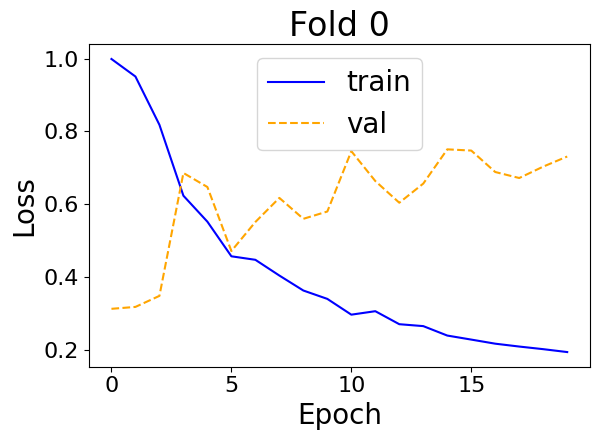

/opt/python/lib/python3.13/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.15501028299331665    │
│          test/r2          │    0.7962549924850464     │
│         test/rmse         │    0.19384485483169556    │
└───────────────────────────┴───────────────────────────┘

/opt/python/lib/python3.13/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.

CV iteration 1


/opt/python/lib/python3.13/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /home/onyxia/work/checkpoints exists and is not empty.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


/opt/python/lib/python3.13/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.4102661907672882     │
│          test/r2          │    -0.6117382049560547    │
│         test/rmse         │    0.5730363726615906     │
└───────────────────────────┴───────────────────────────┘

/opt/python/lib/python3.13/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.

CV iteration 2


/opt/python/lib/python3.13/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /home/onyxia/work/checkpoints exists and is not empty.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


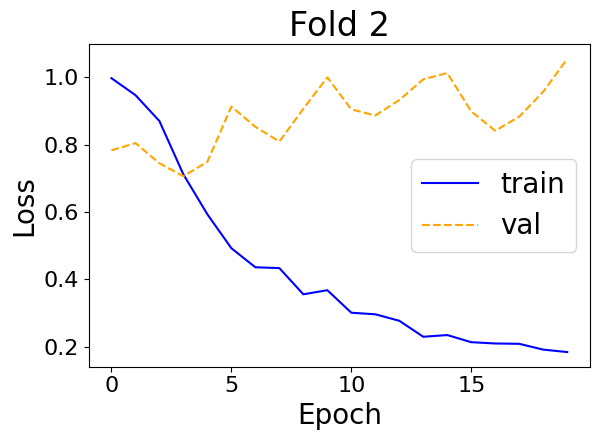

/opt/python/lib/python3.13/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.26615023612976074    │
│          test/r2          │    0.6402775049209595     │
│         test/rmse         │    0.39364442229270935    │
└───────────────────────────┴───────────────────────────┘

/opt/python/lib/python3.13/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.

CV iteration 3


/opt/python/lib/python3.13/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /home/onyxia/work/checkpoints exists and is not empty.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


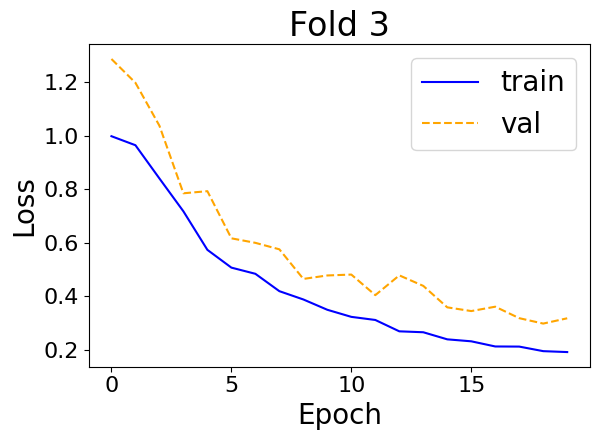

/opt/python/lib/python3.13/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.21876974403858185    │
│          test/r2          │    0.6773645281791687     │
│         test/rmse         │    0.3030414879322052     │
└───────────────────────────┴───────────────────────────┘

/opt/python/lib/python3.13/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.

CV iteration 4


/opt/python/lib/python3.13/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /home/onyxia/work/checkpoints exists and is not empty.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


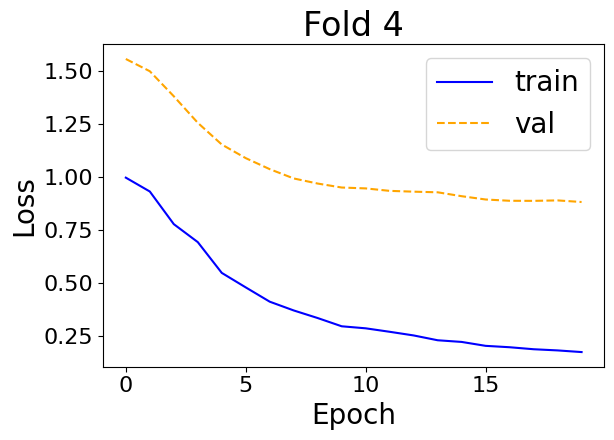

/opt/python/lib/python3.13/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │     0.216449573636055     │
│          test/r2          │    0.7252753973007202     │
│         test/rmse         │    0.27775609493255615    │
└───────────────────────────┴───────────────────────────┘

/opt/python/lib/python3.13/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.

CV iteration 5


/opt/python/lib/python3.13/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /home/onyxia/work/checkpoints exists and is not empty.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


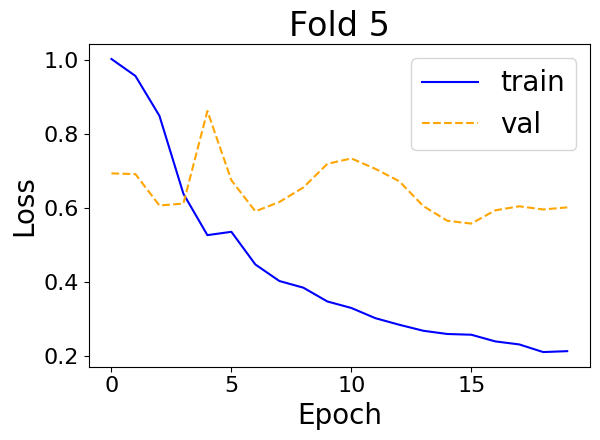

/opt/python/lib/python3.13/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.13132482767105103    │
│          test/r2          │    0.7386292219161987     │
│         test/rmse         │    0.2079414278268814     │
└───────────────────────────┴───────────────────────────┘

CV iteration 6


/opt/python/lib/python3.13/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.

/opt/python/lib/python3.13/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /home/onyxia/work/checkpoints exists and is not empty.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


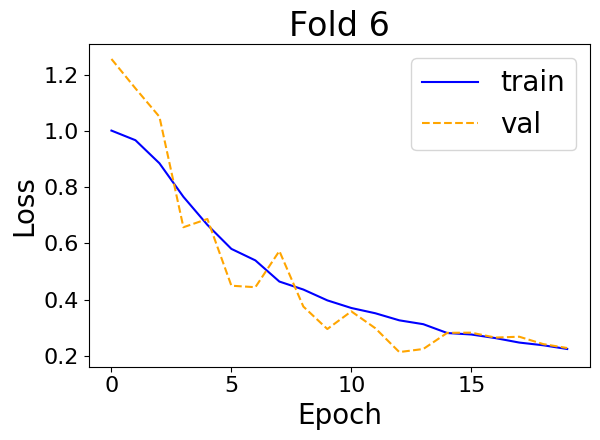

/opt/python/lib/python3.13/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.18998241424560547    │
│          test/r2          │    0.7656947374343872     │
│         test/rmse         │    0.22142291069030762    │
└───────────────────────────┴───────────────────────────┘

/opt/python/lib/python3.13/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.

CV iteration 7


/opt/python/lib/python3.13/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /home/onyxia/work/checkpoints exists and is not empty.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


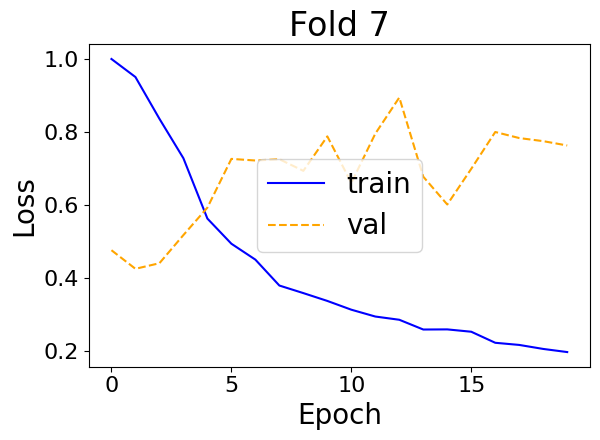

/opt/python/lib/python3.13/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.20699280500411987    │
│          test/r2          │    0.7683721780776978     │
│         test/rmse         │    0.30596500635147095    │
└───────────────────────────┴───────────────────────────┘

/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


/opt/python/lib/python3.13/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.

CV iteration 8


/opt/python/lib/python3.13/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /home/onyxia/work/checkpoints exists and is not empty.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


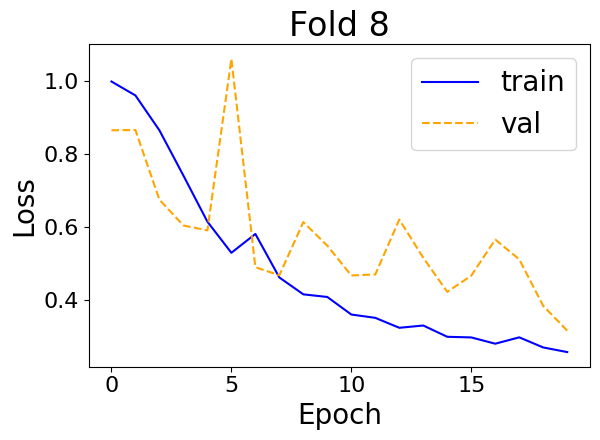

/opt/python/lib/python3.13/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.2646426558494568     │
│          test/r2          │    0.7274511456489563     │
│         test/rmse         │    0.40776923298835754    │
└───────────────────────────┴───────────────────────────┘

/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


/opt/python/lib/python3.13/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.

CV iteration 9


/opt/python/lib/python3.13/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /home/onyxia/work/checkpoints exists and is not empty.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


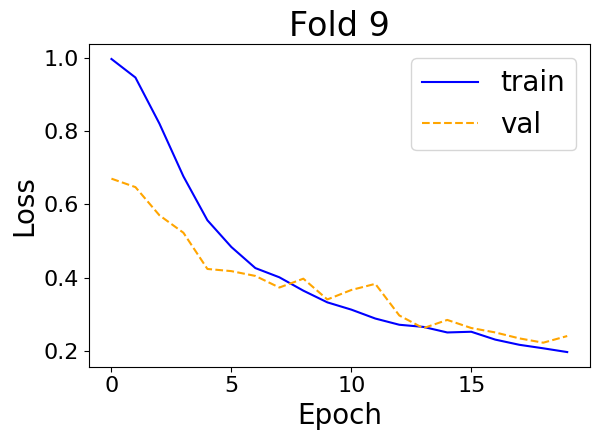

/opt/python/lib/python3.13/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.24281708896160126    │
│          test/r2          │    0.5977455377578735     │
│         test/rmse         │    0.28552132844924927    │
└───────────────────────────┴───────────────────────────┘

Total training time: 345.80 seconds (5.76 minutes)
{'MAE': 0.28836249911928946, 'RMSE': np.float64(0.4199626612598457), 'Ratio': np.float64(1.45637058404781), 'R² Score': 0.4389767316271562}


In [16]:
y_data_hela, y_predictions_hela = cross_validation_chemeleon(all_data_hela, indices_hela)

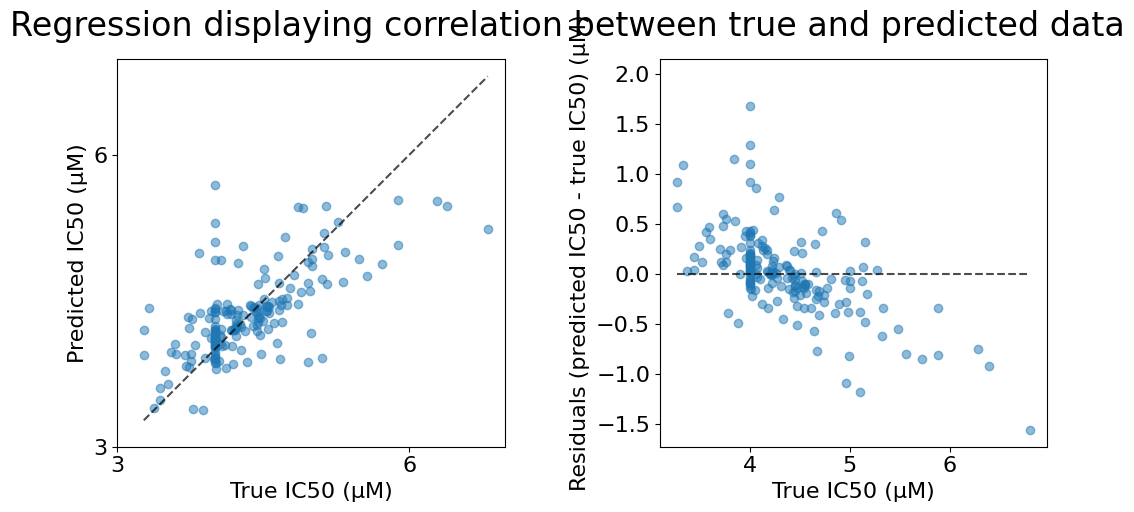

In [17]:
plot_cv_results(y_data_hela, y_predictions_hela)

## DOI split

In [10]:
indices_DOI = get_indices_chemeleon_DOI(df_input, 10)

train length : 582 | val length : 78 | test length : 58
train length : 570 | val length : 78 | test length : 70
train length : 580 | val length : 78 | test length : 60
train length : 563 | val length : 78 | test length : 77
train length : 575 | val length : 78 | test length : 65
train length : 577 | val length : 78 | test length : 63
train length : 551 | val length : 78 | test length : 89
train length : 568 | val length : 78 | test length : 72
train length : 559 | val length : 78 | test length : 81
train length : 558 | val length : 77 | test length : 83


/opt/python/lib/python3.13/site-packages/rich/live.py:260: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.

CV iteration 0


/opt/python/lib/python3.13/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /home/onyxia/work/checkpoints exists and is not empty.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


/opt/python/lib/python3.13/site-packages/rich/live.py:260: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.5542647242546082     │
│          test/r2          │    0.19908565282821655    │
│         test/rmse         │    0.7064008116722107     │
└───────────────────────────┴───────────────────────────┘

/opt/python/lib/python3.13/site-packages/rich/live.py:260: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.

CV iteration 1


/opt/python/lib/python3.13/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /home/onyxia/work/checkpoints exists and is not empty.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


/opt/python/lib/python3.13/site-packages/rich/live.py:260: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.18162350356578827    │
│          test/r2          │     0.917375385761261     │
│         test/rmse         │    0.23950402438640594    │
└───────────────────────────┴───────────────────────────┘

/opt/python/lib/python3.13/site-packages/rich/live.py:260: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.

CV iteration 2


/opt/python/lib/python3.13/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /home/onyxia/work/checkpoints exists and is not empty.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


/opt/python/lib/python3.13/site-packages/rich/live.py:260: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.22235345840454102    │
│          test/r2          │    0.7469278573989868     │
│         test/rmse         │    0.2940559685230255     │
└───────────────────────────┴───────────────────────────┘

/opt/python/lib/python3.13/site-packages/rich/live.py:260: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.

CV iteration 3


/opt/python/lib/python3.13/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /home/onyxia/work/checkpoints exists and is not empty.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


/opt/python/lib/python3.13/site-packages/rich/live.py:260: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.17465373873710632    │
│          test/r2          │    0.8553080558776855     │
│         test/rmse         │    0.2554263174533844     │
└───────────────────────────┴───────────────────────────┘

Dropping last batch of size 1 to avoid issues with batch normalization     (dataset size = 65, batch_size = 64)


/opt/python/lib/python3.13/site-packages/rich/live.py:260: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.

CV iteration 4


/opt/python/lib/python3.13/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /home/onyxia/work/checkpoints exists and is not empty.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


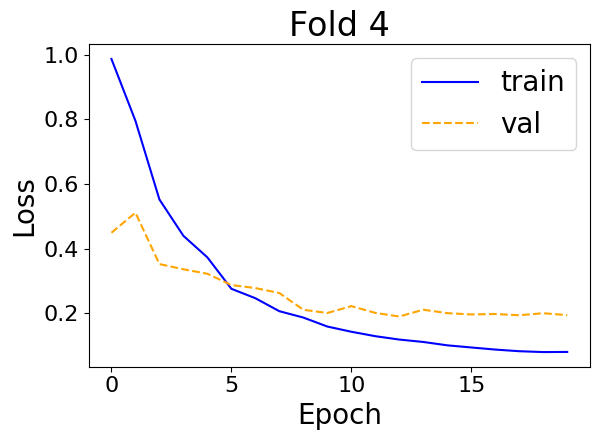

/opt/python/lib/python3.13/site-packages/rich/live.py:260: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.6884632110595703     │
│          test/r2          │   0.038898348808288574    │
│         test/rmse         │    0.9148262739181519     │
└───────────────────────────┴───────────────────────────┘

Dropping last batch of size 1 to avoid issues with batch normalization     (dataset size = 577, batch_size = 64)


/opt/python/lib/python3.13/site-packages/rich/live.py:260: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.

CV iteration 5


/opt/python/lib/python3.13/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /home/onyxia/work/checkpoints exists and is not empty.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


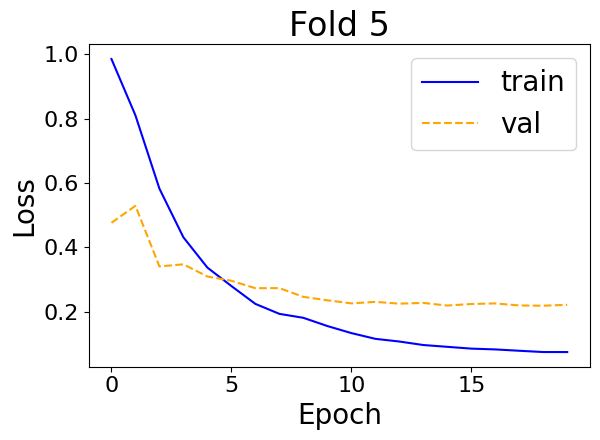

/opt/python/lib/python3.13/site-packages/rich/live.py:260: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.19770051538944244    │
│          test/r2          │    0.8259613513946533     │
│         test/rmse         │    0.2886432707309723     │
└───────────────────────────┴───────────────────────────┘

/opt/python/lib/python3.13/site-packages/rich/live.py:260: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.

CV iteration 6


/opt/python/lib/python3.13/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /home/onyxia/work/checkpoints exists and is not empty.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


/opt/python/lib/python3.13/site-packages/rich/live.py:260: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.20635806024074554    │
│          test/r2          │    0.8582279086112976     │
│         test/rmse         │    0.27923092246055603    │
└───────────────────────────┴───────────────────────────┘

/opt/python/lib/python3.13/site-packages/rich/live.py:260: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.

CV iteration 7


/opt/python/lib/python3.13/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /home/onyxia/work/checkpoints exists and is not empty.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


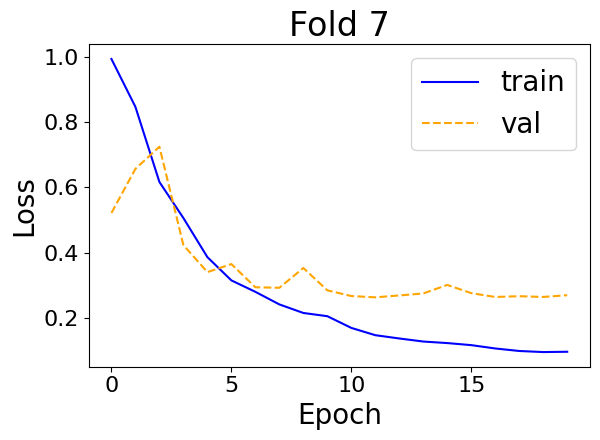

/opt/python/lib/python3.13/site-packages/rich/live.py:260: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.1893058717250824     │
│          test/r2          │    0.9541958570480347     │
│         test/rmse         │    0.25189873576164246    │
└───────────────────────────┴───────────────────────────┘

/opt/python/lib/python3.13/site-packages/rich/live.py:260: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.

CV iteration 8


/opt/python/lib/python3.13/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /home/onyxia/work/checkpoints exists and is not empty.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


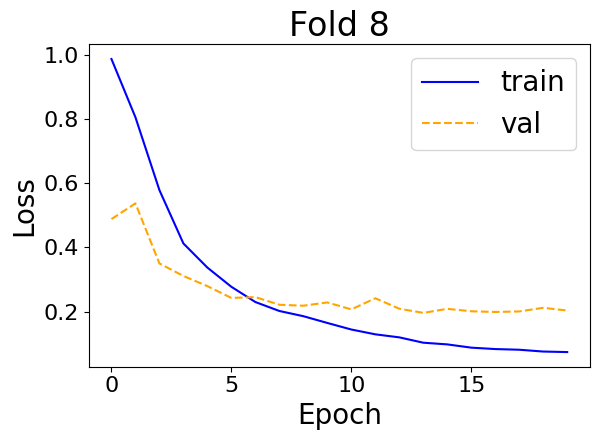

/opt/python/lib/python3.13/site-packages/rich/live.py:260: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.1936541050672531     │
│          test/r2          │     0.865494966506958     │
│         test/rmse         │    0.2468005269765854     │
└───────────────────────────┴───────────────────────────┘

/opt/python/lib/python3.13/site-packages/rich/live.py:260: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.

CV iteration 9


/opt/python/lib/python3.13/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /home/onyxia/work/checkpoints exists and is not empty.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


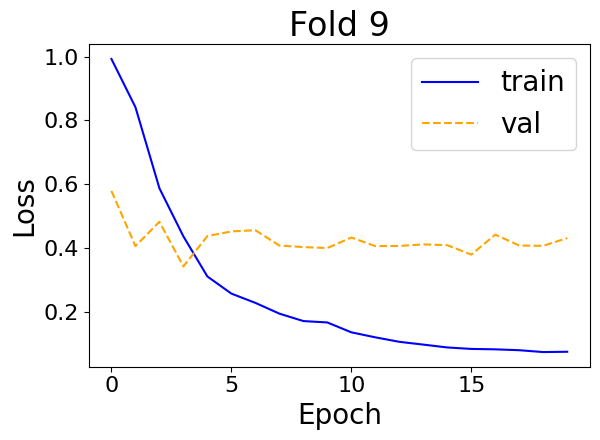

/opt/python/lib/python3.13/site-packages/rich/live.py:260: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.2820652425289154     │
│          test/r2          │    0.42430633306503296    │
│         test/rmse         │    0.3575740456581116     │
└───────────────────────────┴───────────────────────────┘

Total training time: 1246.80 seconds (20.78 minutes)
{'MAE': 0.5113581404219445, 'RMSE': np.float64(0.6803381841823021), 'Ratio': np.float64(1.3304534149410912), 'R² Score': 0.3346535582906962}


In [11]:
y_data_DOI, y_predictions_DOI = cross_validation_chemeleon(all_data, indices_DOI)

In [22]:
plot_cv_results(y_data_DOI, y_predictions_DOI)

### DOI split without pre-training (not loading state_dict)

In [ ]:
indices_DOI_2 = get_indices_chemeleon_DOI(df_input, 10)

train length : 603 | val length : 51 | test length : 64
train length : 585 | val length : 51 | test length : 82
train length : 573 | val length : 51 | test length : 94
train length : 606 | val length : 51 | test length : 61
train length : 594 | val length : 51 | test length : 73
train length : 599 | val length : 51 | test length : 68
train length : 595 | val length : 51 | test length : 72
train length : 583 | val length : 51 | test length : 84
train length : 604 | val length : 51 | test length : 63
train length : 604 | val length : 57 | test length : 57


CV iteration 0


Output()

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /content/checkpoints exists and is not empty.


Output()

Output()

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │     0.367097944021225     │
│          test/r2          │    0.6215202808380127     │
│         test/rmse         │    0.4330703318119049     │
└───────────────────────────┴───────────────────────────┘

Output()

CV iteration 1


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /content/checkpoints exists and is not empty.


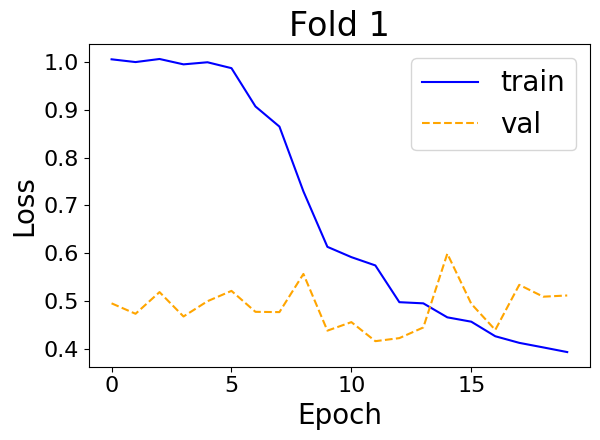

Output()

Output()

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.37287646532058716    │
│          test/r2          │    0.7044185400009155     │
│         test/rmse         │    0.4670178294181824     │
└───────────────────────────┴───────────────────────────┘

Output()

CV iteration 2


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /content/checkpoints exists and is not empty.


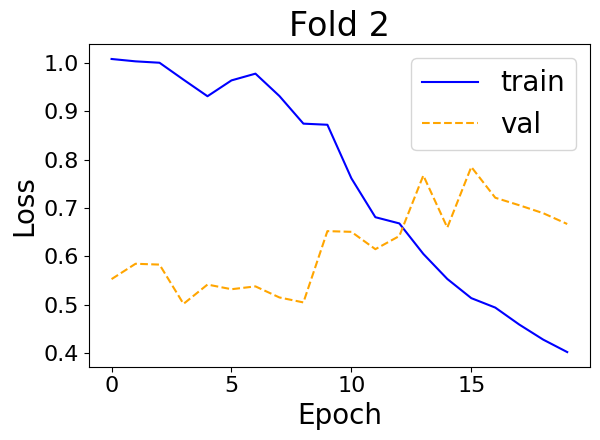

Output()

Output()

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.3772355020046234     │
│          test/r2          │    0.8477082848548889     │
│         test/rmse         │    0.46317264437675476    │
└───────────────────────────┴───────────────────────────┘

Output()

CV iteration 3


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /content/checkpoints exists and is not empty.


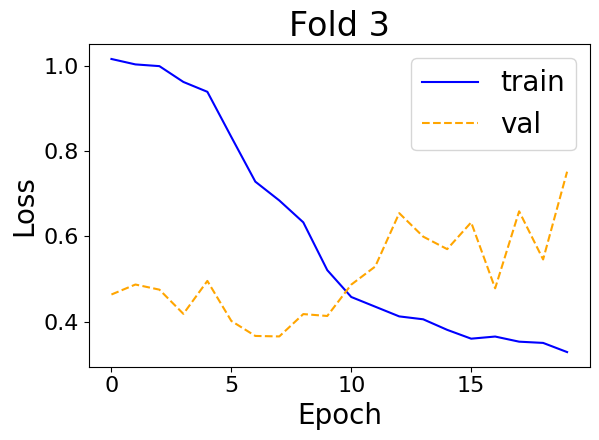

Output()

Output()

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.39970001578330994    │
│          test/r2          │    0.40042078495025635    │
│         test/rmse         │    0.5162407755851746     │
└───────────────────────────┴───────────────────────────┘

Output()

CV iteration 4


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /content/checkpoints exists and is not empty.


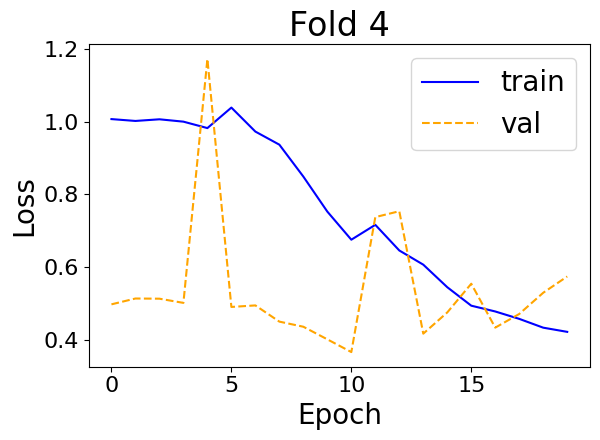

Output()

Output()

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.33841782808303833    │
│          test/r2          │    0.5402045845985413     │
│         test/rmse         │    0.4365803301334381     │
└───────────────────────────┴───────────────────────────┘

Output()

CV iteration 5


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /content/checkpoints exists and is not empty.


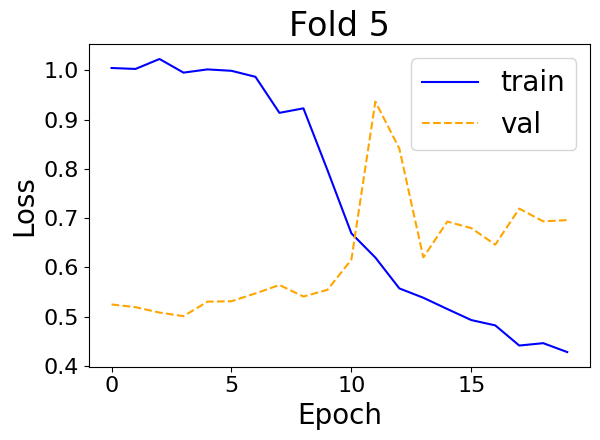

Output()

Output()

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.4463554620742798     │
│          test/r2          │    0.6839016675949097     │
│         test/rmse         │    0.5793988108634949     │
└───────────────────────────┴───────────────────────────┘

CV iteration 6


Output()

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /content/checkpoints exists and is not empty.


Output()

Output()

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.3726058006286621     │
│          test/r2          │    0.4486016035079956     │
│         test/rmse         │    0.5562118887901306     │
└───────────────────────────┴───────────────────────────┘

Output()

CV iteration 7


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /content/checkpoints exists and is not empty.


Output()

Output()

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.3435588479042053     │
│          test/r2          │    0.4096744656562805     │
│         test/rmse         │    0.45168182253837585    │
└───────────────────────────┴───────────────────────────┘

Output()

CV iteration 8


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /content/checkpoints exists and is not empty.


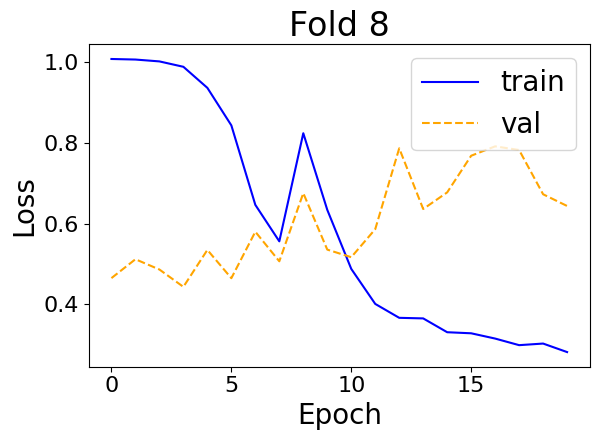

Output()

Output()

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.46497201919555664    │
│          test/r2          │    0.4461851716041565     │
│         test/rmse         │    0.5267407298088074     │
└───────────────────────────┴───────────────────────────┘

Output()

CV iteration 9


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /content/checkpoints exists and is not empty.


Output()

Output()

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.45880937576293945    │
│          test/r2          │    -0.4285283088684082    │
│         test/rmse         │    0.6627364158630371     │
└───────────────────────────┴───────────────────────────┘

Total training time: 807.36 seconds (13.46 minutes)
{'MAE': 0.5659168611571764, 'RMSE': np.float64(0.7480389010695464), 'Ratio': np.float64(1.3218176598236888), 'R² Score': 0.19564732111197247}


In [ ]:
y_data_DOI_2, y_predictions_DOI_2 = cross_validation_chemeleon_no_pre_training(all_data, indices_DOI_2)

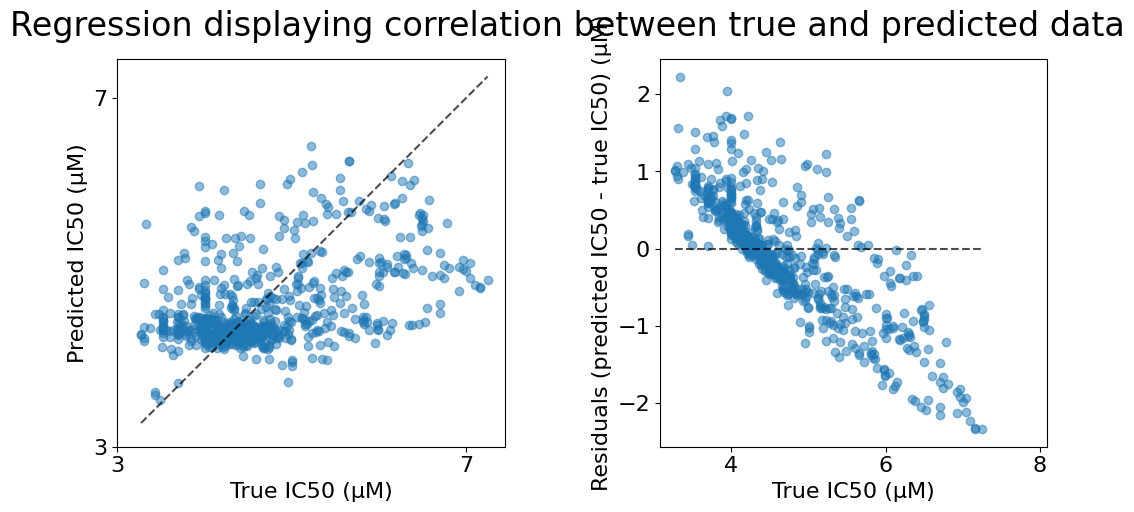

In [ ]:
plot_cv_results(y_data_DOI_2, y_predictions_DOI_2)

## Scaffold split

### Scaffold A

In [ ]:
df_input = swap_identical_ligands(df_input)
df_input['MOL1'] = df_input['L1'].apply(Chem.MolFromSmiles)
molsA = df_input['MOL1'].tolist()


In [ ]:
indices_scaff_A = get_indices_chemeleon_scaff(molsA, 10, seeder = 1)

100%|██████████| 718/718 [00:00<00:00, 7605.38it/s]

train length : 685, scaffolds : 24 | val length : 28, scaffolds : 3 | test length : 5, scaffolds : 3
train length : 677, scaffolds : 24 | val length : 28, scaffolds : 3 | test length : 13, scaffolds : 3
train length : 620, scaffolds : 24 | val length : 28, scaffolds : 3 | test length : 70, scaffolds : 3
train length : 623, scaffolds : 24 | val length : 87, scaffolds : 3 | test length : 8, scaffolds : 3
train length : 626, scaffolds : 24 | val length : 72, scaffolds : 3 | test length : 20, scaffolds : 3
train length : 615, scaffolds : 24 | val length : 65, scaffolds : 3 | test length : 38, scaffolds : 3
train length : 634, scaffolds : 24 | val length : 65, scaffolds : 3 | test length : 19, scaffolds : 3
train length : 647, scaffolds : 24 | val length : 65, scaffolds : 3 | test length : 6, scaffolds : 3
train length : 337, scaffolds : 24 | val length : 65, scaffolds : 3 | test length : 316, scaffolds : 3
train length : 430, scaffolds : 24 | val length : 65, scaffolds : 3 | test length : 

Output()

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /content/checkpoints exists and is not empty.


CV iteration 0


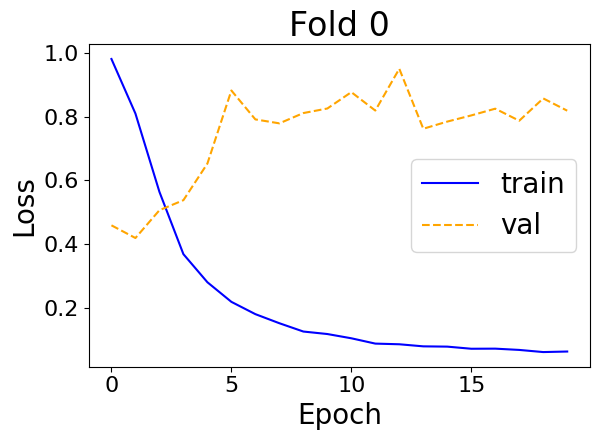

Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.4015771448612213     │
│          test/r2          │    0.03256559371948242    │
│         test/rmse         │    0.4676160216331482     │
└───────────────────────────┴───────────────────────────┘

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


Output()

CV iteration 1


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /content/checkpoints exists and is not empty.


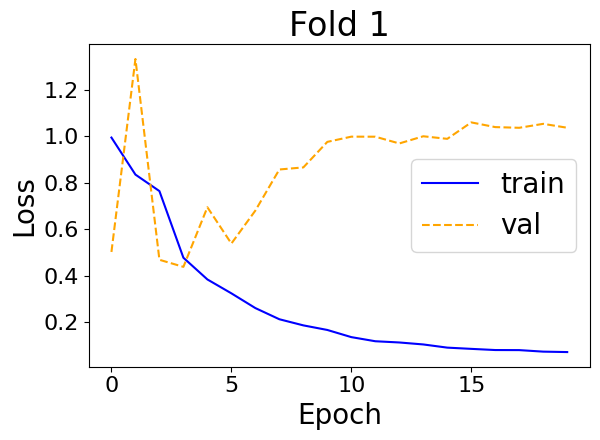

Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.1952429860830307     │
│          test/r2          │    0.8537720441818237     │
│         test/rmse         │    0.3051503300666809     │
└───────────────────────────┴───────────────────────────┘

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


Output()

CV iteration 2


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /content/checkpoints exists and is not empty.


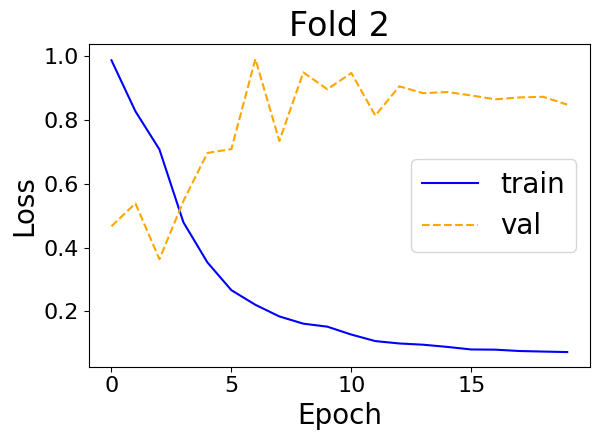

Output()

Output()

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.24488337337970734    │
│          test/r2          │    0.7713442444801331     │
│         test/rmse         │    0.34990277886390686    │
└───────────────────────────┴───────────────────────────┘

CV iteration 3


Output()

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /content/checkpoints exists and is not empty.


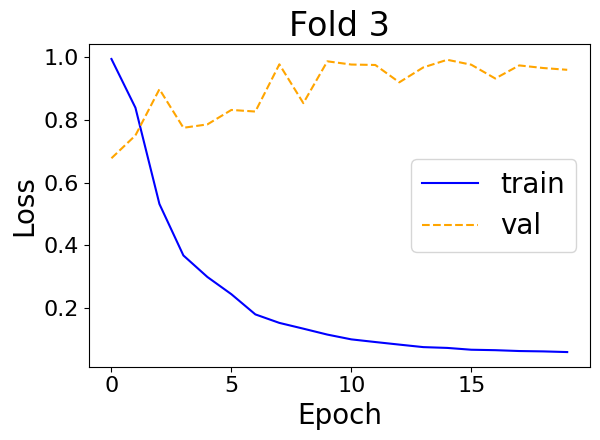

Output()

Output()

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.22774377465248108    │
│          test/r2          │    0.20054185390472412    │
│         test/rmse         │    0.36089637875556946    │
└───────────────────────────┴───────────────────────────┘

CV iteration 4


Output()

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /content/checkpoints exists and is not empty.


Output()

Output()

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.2732868194580078     │
│          test/r2          │    0.5562481880187988     │
│         test/rmse         │    0.35708296298980713    │
└───────────────────────────┴───────────────────────────┘

CV iteration 5


Output()

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /content/checkpoints exists and is not empty.


Output()

Output()

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │     0.228202223777771     │
│          test/r2          │    0.7204035520553589     │
│         test/rmse         │    0.30259594321250916    │
└───────────────────────────┴───────────────────────────┘

Output()

CV iteration 6


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /content/checkpoints exists and is not empty.


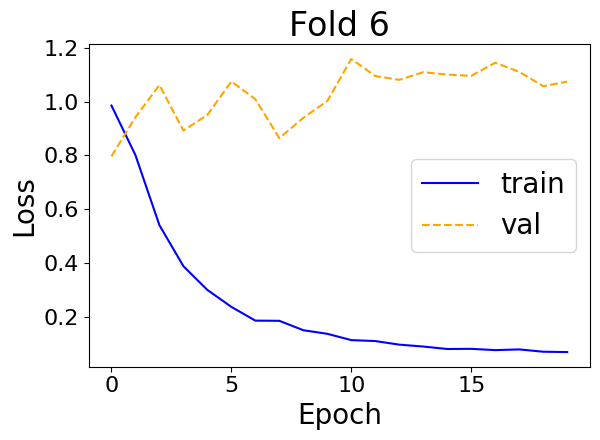

Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.20383034646511078    │
│          test/r2          │    0.7383003234863281     │
│         test/rmse         │    0.3599436283111572     │
└───────────────────────────┴───────────────────────────┘

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


Output()

CV iteration 7


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /content/checkpoints exists and is not empty.


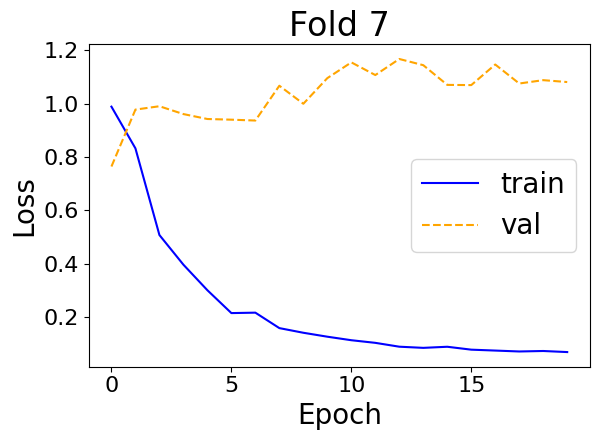

Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.0612814836204052     │
│          test/r2          │    0.9753736853599548     │
│         test/rmse         │    0.07883371412754059    │
└───────────────────────────┴───────────────────────────┘

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


Output()

CV iteration 8


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /content/checkpoints exists and is not empty.


Output()

Output()

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.1819276511669159     │
│          test/r2          │    0.8647541999816895     │
│         test/rmse         │    0.2687724828720093     │
└───────────────────────────┴───────────────────────────┘

Output()

CV iteration 9


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /content/checkpoints exists and is not empty.


Output()

Output()

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.1806502342224121     │
│          test/r2          │     0.932870626449585     │
│         test/rmse         │    0.24759730696678162    │
└───────────────────────────┴───────────────────────────┘

Total training time: 789.88 seconds (13.16 minutes)
{'MAE': 0.534767976756483, 'RMSE': np.float64(0.7484756036115134), 'Ratio': np.float64(1.3996268216193999), 'R² Score': 0.19470789030955915}


In [ ]:
y_data_scaff_A, y_predictions_scaff_A = cross_validation_chemeleon(all_data, indices_scaff_A)

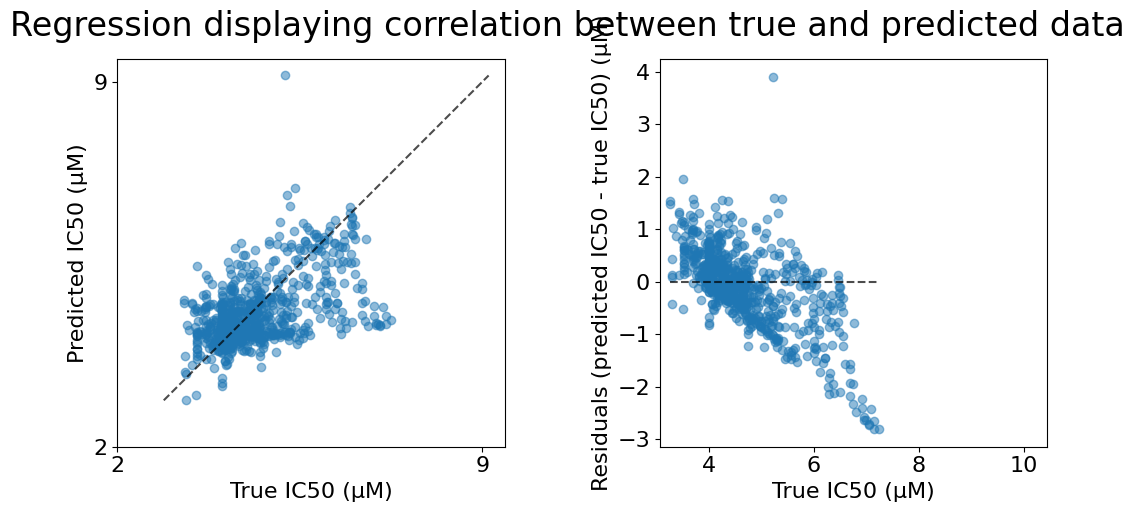

In [ ]:
plot_cv_results(y_data_scaff_A, y_predictions_scaff_A)

#### Without pre-training

In [ ]:
indices_scaff_A_2 = get_indices_chemeleon_scaff(molsA, 10, seeder = 1)

100%|██████████| 718/718 [00:00<00:00, 4781.66it/s]

train length : 685, scaffolds : 24 | val length : 28, scaffolds : 3 | test length : 5, scaffolds : 3
train length : 677, scaffolds : 24 | val length : 28, scaffolds : 3 | test length : 13, scaffolds : 3
train length : 620, scaffolds : 24 | val length : 28, scaffolds : 3 | test length : 70, scaffolds : 3
train length : 623, scaffolds : 24 | val length : 87, scaffolds : 3 | test length : 8, scaffolds : 3
train length : 626, scaffolds : 24 | val length : 72, scaffolds : 3 | test length : 20, scaffolds : 3
train length : 615, scaffolds : 24 | val length : 65, scaffolds : 3 | test length : 38, scaffolds : 3
train length : 634, scaffolds : 24 | val length : 65, scaffolds : 3 | test length : 19, scaffolds : 3
train length : 647, scaffolds : 24 | val length : 65, scaffolds : 3 | test length : 6, scaffolds : 3
train length : 337, scaffolds : 24 | val length : 65, scaffolds : 3 | test length : 316, scaffolds : 3
train length : 430, scaffolds : 24 | val length : 65, scaffolds : 3 | test length : 

CV iteration 0


Output()

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /content/checkpoints exists and is not empty.


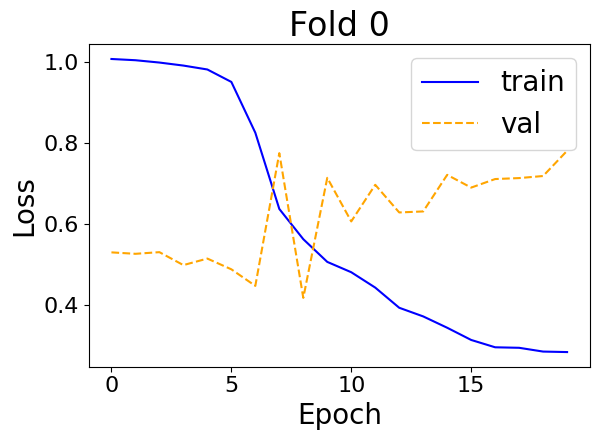

Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.41998711228370667    │
│          test/r2          │    -0.5211547613143921    │
│         test/rmse         │     0.586361289024353     │
└───────────────────────────┴───────────────────────────┘

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


CV iteration 1


Output()

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /content/checkpoints exists and is not empty.


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │     0.512108564376831     │
│          test/r2          │    0.46533143520355225    │
│         test/rmse         │    0.5835001468658447     │
└───────────────────────────┴───────────────────────────┘

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


Output()

CV iteration 2


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /content/checkpoints exists and is not empty.


Output()

Output()

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.46095243096351624    │
│          test/r2          │    0.41954249143600464    │
│         test/rmse         │    0.5574957132339478     │
└───────────────────────────┴───────────────────────────┘

Output()

CV iteration 3


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /content/checkpoints exists and is not empty.


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.2229384183883667     │
│          test/r2          │    0.33526211977005005    │
│         test/rmse         │    0.3290863633155823     │
└───────────────────────────┴───────────────────────────┘

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


Output()

CV iteration 4


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /content/checkpoints exists and is not empty.


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │     0.492436021566391     │
│          test/r2          │   -0.21133840084075928    │
│         test/rmse         │    0.5899725556373596     │
└───────────────────────────┴───────────────────────────┘

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


Output()

CV iteration 5


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /content/checkpoints exists and is not empty.


Output()

Output()

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.30039888620376587    │
│          test/r2          │    0.5018188953399658     │
│         test/rmse         │    0.4039158523082733     │
└───────────────────────────┴───────────────────────────┘

Output()

CV iteration 6


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /content/checkpoints exists and is not empty.


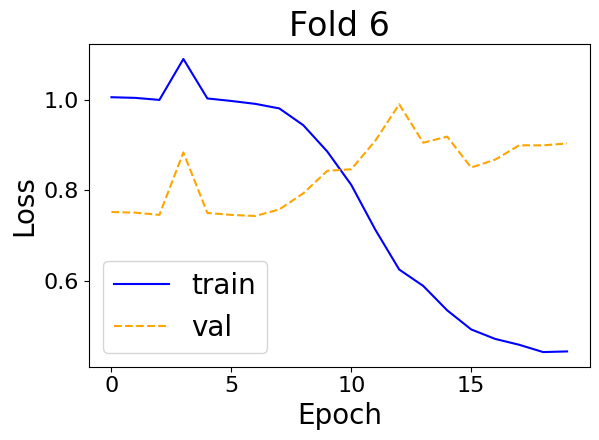

Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.4628174901008606     │
│          test/r2          │    0.2617173194885254     │
│         test/rmse         │    0.6045666933059692     │
└───────────────────────────┴───────────────────────────┘

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


Output()

CV iteration 7


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /content/checkpoints exists and is not empty.


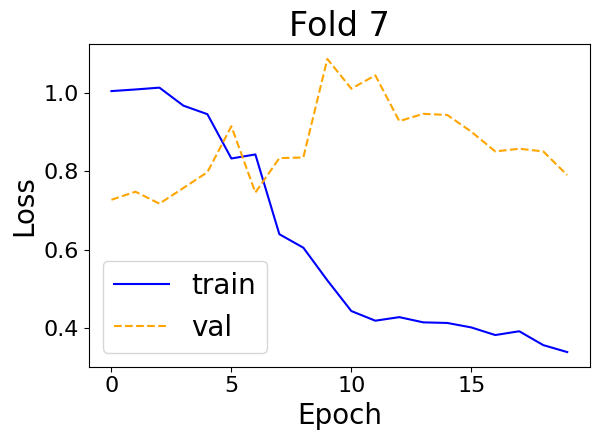

Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.33030447363853455    │
│          test/r2          │    -0.4518001079559326    │
│         test/rmse         │     0.605293333530426     │
└───────────────────────────┴───────────────────────────┘

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


Output()

CV iteration 8


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /content/checkpoints exists and is not empty.


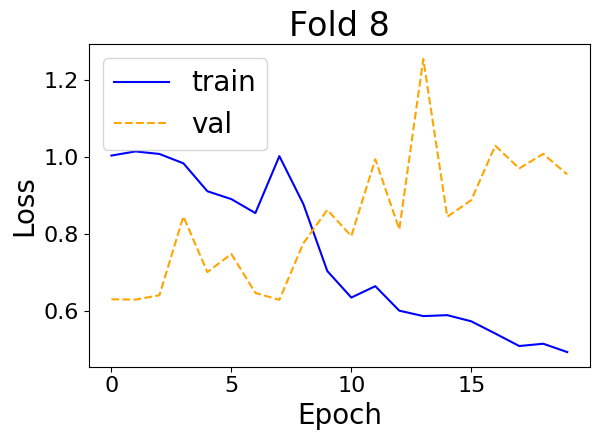

Output()

Output()

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.35068702697753906    │
│          test/r2          │    0.5999389886856079     │
│         test/rmse         │    0.46225976943969727    │
└───────────────────────────┴───────────────────────────┘

Output()

CV iteration 9


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /content/checkpoints exists and is not empty.


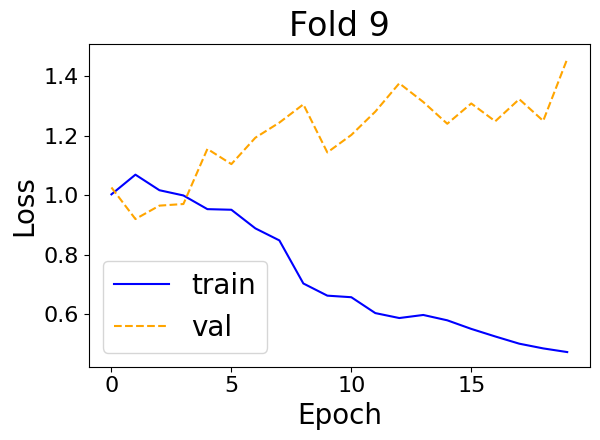

Output()

Output()

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.4234830141067505     │
│          test/r2          │    0.6740295886993408     │
│         test/rmse         │    0.5456055402755737     │
└───────────────────────────┴───────────────────────────┘

Total training time: 802.23 seconds (13.37 minutes)
{'MAE': 0.6467774756495331, 'RMSE': np.float64(0.8668999382919331), 'Ratio': np.float64(1.3403372426062605), 'R² Score': -0.08027938763325815}


In [ ]:
y_data_scaff_A_2, y_predictions_scaff_A_2 = cross_validation_chemeleon_no_pre_training(all_data, indices_scaff_A_2)

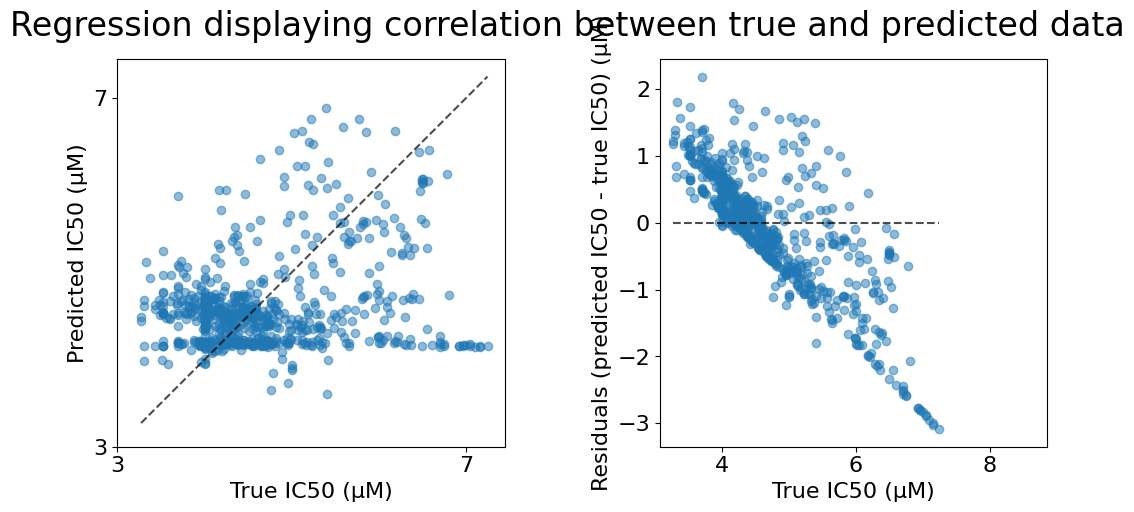

In [ ]:
plot_cv_results(y_data_scaff_A_2, y_predictions_scaff_A_2)

### Scaffold B

In [13]:
df_input['MOL3'] = df_input['L3'].apply(Chem.MolFromSmiles)
molsB = df_input['MOL3'].tolist()

In [14]:
indices_scaff_B = get_indices_chemeleon_scaff(molsB, 10)

100%|██████████| 718/718 [00:00<00:00, 4671.20it/s]

train length : 529, scaffolds : 162 | val length : 35, scaffolds : 18 | test length : 154, scaffolds : 20
train length : 569, scaffolds : 162 | val length : 36, scaffolds : 18 | test length : 113, scaffolds : 20
train length : 638, scaffolds : 162 | val length : 39, scaffolds : 18 | test length : 41, scaffolds : 20
train length : 593, scaffolds : 162 | val length : 46, scaffolds : 18 | test length : 79, scaffolds : 20
train length : 626, scaffolds : 162 | val length : 47, scaffolds : 18 | test length : 45, scaffolds : 20
train length : 572, scaffolds : 162 | val length : 44, scaffolds : 18 | test length : 102, scaffolds : 20
train length : 633, scaffolds : 162 | val length : 46, scaffolds : 18 | test length : 39, scaffolds : 20
train length : 620, scaffolds : 162 | val length : 41, scaffolds : 18 | test length : 57, scaffolds : 20
train length : 615, scaffolds : 162 | val length : 52, scaffolds : 18 | test length : 51, scaffolds : 20
train length : 629, scaffolds : 162 | val length : 5

/opt/python/lib/python3.13/site-packages/rich/live.py:260: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.

/opt/python/lib/python3.13/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /home/onyxia/work/checkpoints exists and is not empty.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


CV iteration 0


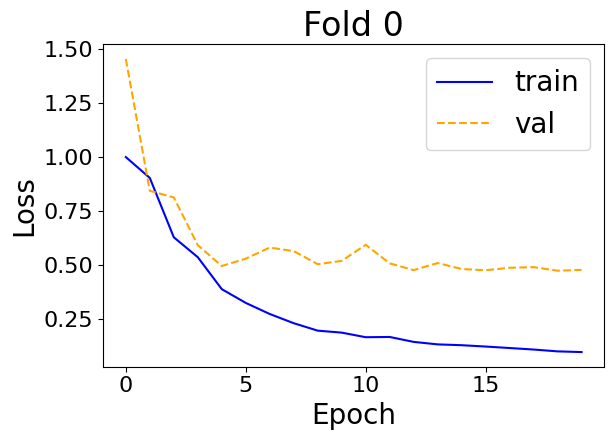

/opt/python/lib/python3.13/site-packages/rich/live.py:260: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.20570038259029388    │
│          test/r2          │     0.915988028049469     │
│         test/rmse         │    0.28768593072891235    │
└───────────────────────────┴───────────────────────────┘

/opt/python/lib/python3.13/site-packages/rich/live.py:260: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.

CV iteration 1


/opt/python/lib/python3.13/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /home/onyxia/work/checkpoints exists and is not empty.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


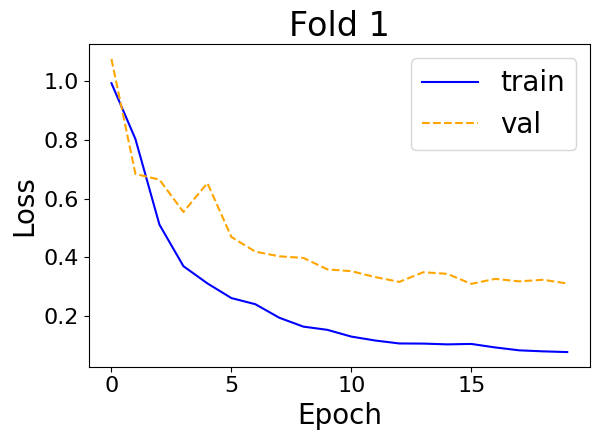

/opt/python/lib/python3.13/site-packages/rich/live.py:260: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.23207512497901917    │
│          test/r2          │    0.7530086636543274     │
│         test/rmse         │    0.31480586528778076    │
└───────────────────────────┴───────────────────────────┘

/opt/python/lib/python3.13/site-packages/rich/live.py:260: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.

CV iteration 2


/opt/python/lib/python3.13/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /home/onyxia/work/checkpoints exists and is not empty.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


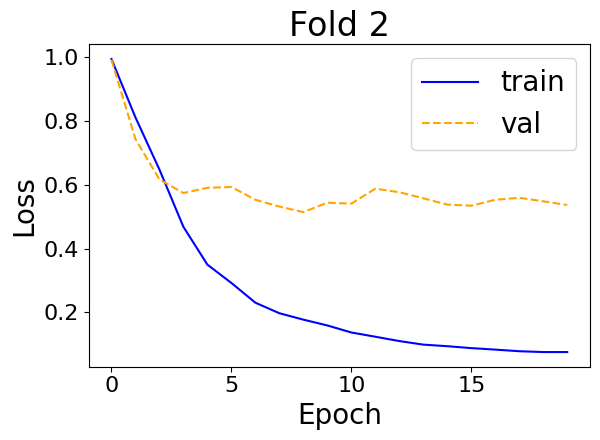

/opt/python/lib/python3.13/site-packages/rich/live.py:260: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.38709649443626404    │
│          test/r2          │    0.6797020435333252     │
│         test/rmse         │    0.5376047492027283     │
└───────────────────────────┴───────────────────────────┘

/opt/python/lib/python3.13/site-packages/rich/live.py:260: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.

CV iteration 3


/opt/python/lib/python3.13/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /home/onyxia/work/checkpoints exists and is not empty.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


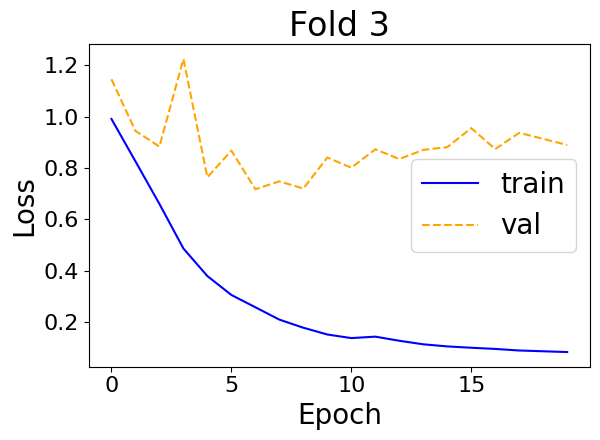

/opt/python/lib/python3.13/site-packages/rich/live.py:260: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.23603275418281555    │
│          test/r2          │    0.8774968385696411     │
│         test/rmse         │    0.3172166645526886     │
└───────────────────────────┴───────────────────────────┘

/opt/python/lib/python3.13/site-packages/rich/live.py:260: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.

CV iteration 4


/opt/python/lib/python3.13/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /home/onyxia/work/checkpoints exists and is not empty.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


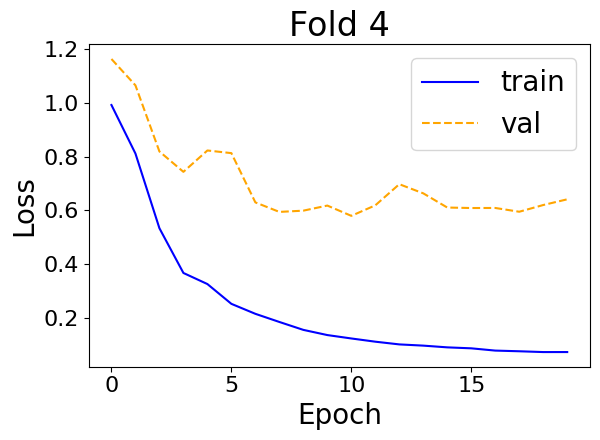

/opt/python/lib/python3.13/site-packages/rich/live.py:260: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.16577884554862976    │
│          test/r2          │     0.830146074295044     │
│         test/rmse         │    0.27961570024490356    │
└───────────────────────────┴───────────────────────────┘

/opt/python/lib/python3.13/site-packages/rich/live.py:260: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.

CV iteration 5


/opt/python/lib/python3.13/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /home/onyxia/work/checkpoints exists and is not empty.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


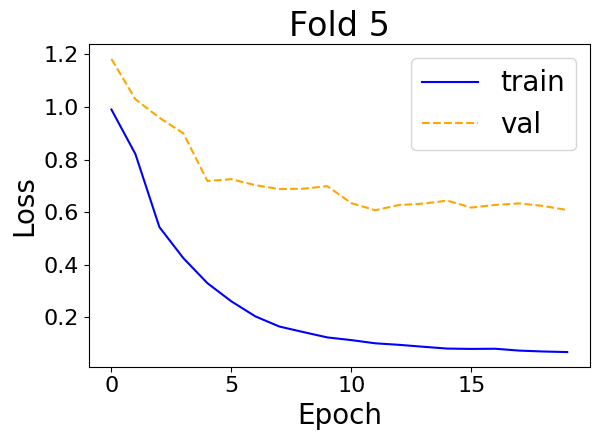

/opt/python/lib/python3.13/site-packages/rich/live.py:260: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.36062532663345337    │
│          test/r2          │    0.2532578110694885     │
│         test/rmse         │    0.6100822687149048     │
└───────────────────────────┴───────────────────────────┘

/opt/python/lib/python3.13/site-packages/rich/live.py:260: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.

CV iteration 6


/opt/python/lib/python3.13/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /home/onyxia/work/checkpoints exists and is not empty.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


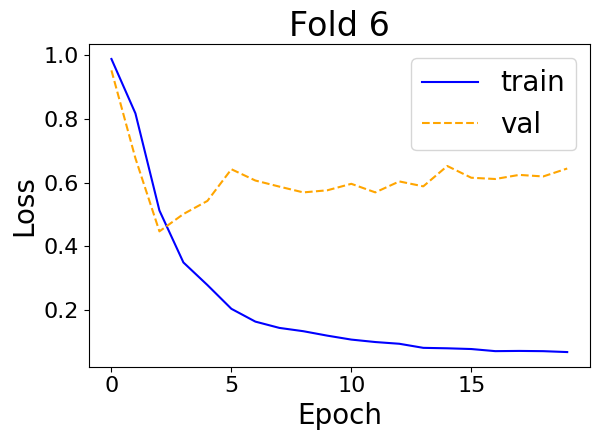

/opt/python/lib/python3.13/site-packages/rich/live.py:260: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.2436327338218689     │
│          test/r2          │    0.8030787706375122     │
│         test/rmse         │    0.3230510652065277     │
└───────────────────────────┴───────────────────────────┘

/opt/python/lib/python3.13/site-packages/rich/live.py:260: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.

CV iteration 7


/opt/python/lib/python3.13/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /home/onyxia/work/checkpoints exists and is not empty.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


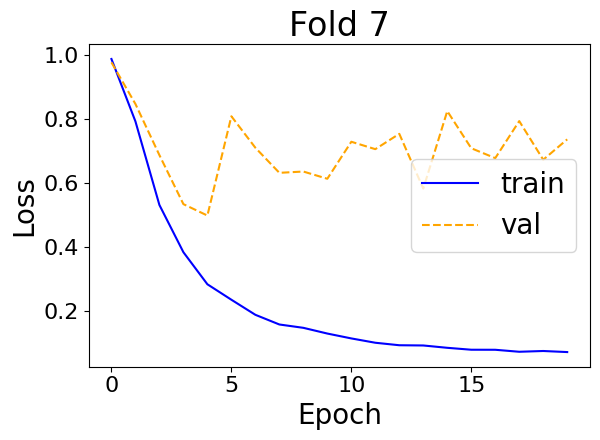

/opt/python/lib/python3.13/site-packages/rich/live.py:260: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.2526148855686188     │
│          test/r2          │    0.7353255152702332     │
│         test/rmse         │    0.3206254541873932     │
└───────────────────────────┴───────────────────────────┘

/opt/python/lib/python3.13/site-packages/rich/live.py:260: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.

CV iteration 8


/opt/python/lib/python3.13/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /home/onyxia/work/checkpoints exists and is not empty.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


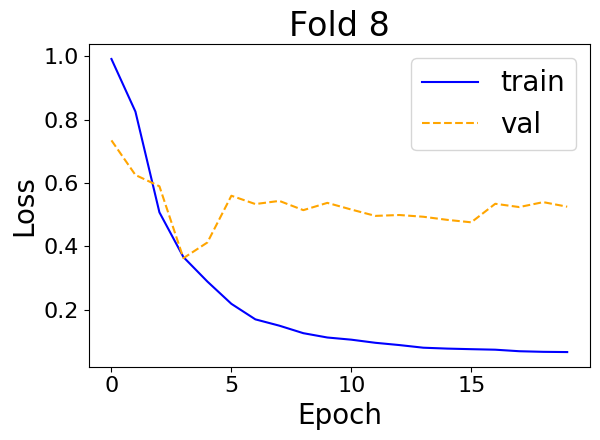

/opt/python/lib/python3.13/site-packages/rich/live.py:260: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.26374709606170654    │
│          test/r2          │    0.8132106065750122     │
│         test/rmse         │    0.35764166712760925    │
└───────────────────────────┴───────────────────────────┘

/opt/python/lib/python3.13/site-packages/rich/live.py:260: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.

CV iteration 9


/opt/python/lib/python3.13/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /home/onyxia/work/checkpoints exists and is not empty.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


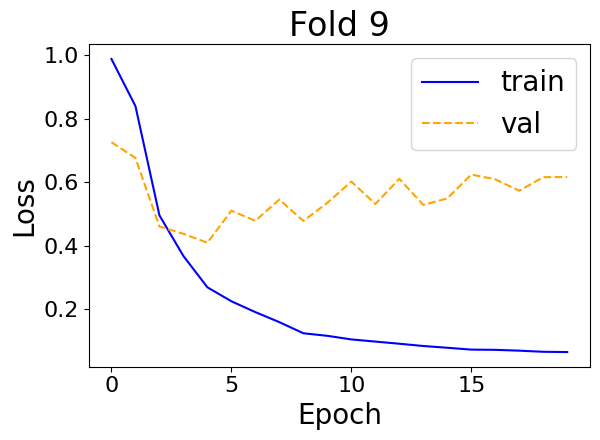

/opt/python/lib/python3.13/site-packages/rich/live.py:260: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
/opt/python/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.2825327217578888     │
│          test/r2          │    0.6972735524177551     │
│         test/rmse         │    0.41820794343948364    │
└───────────────────────────┴───────────────────────────┘

Total training time: 1264.35 seconds (21.07 minutes)
{'MAE': 0.45866423394014055, 'RMSE': np.float64(0.6147690026341357), 'Ratio': np.float64(1.3403465043545735), 'R² Score': 0.4567220621355431}


In [15]:
y_data_scaff_B, y_predictions_scaff_B = cross_validation_chemeleon(all_data, indices_scaff_B)

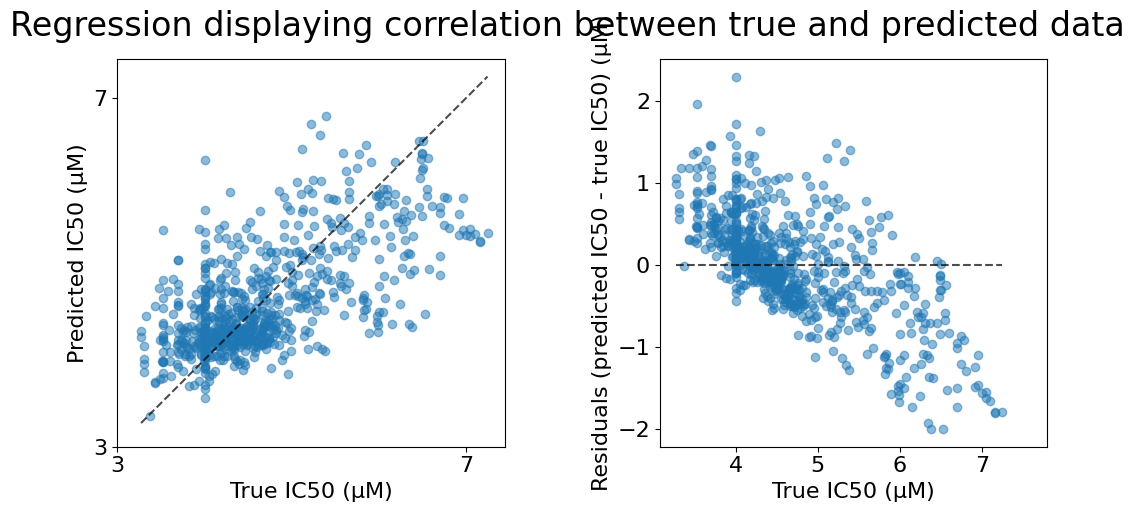

In [29]:
plot_cv_results(y_data_scaff_B, y_predictions_scaff_B)

#### Without pre-training

In [ ]:
indices_scaff_B_2 = get_indices_chemeleon_scaff(molsB, 10, seeder = 1)

100%|██████████| 718/718 [00:00<00:00, 4466.37it/s]

train length : 627, scaffolds : 162 | val length : 51, scaffolds : 18 | test length : 40, scaffolds : 20
train length : 569, scaffolds : 162 | val length : 43, scaffolds : 18 | test length : 106, scaffolds : 20
train length : 549, scaffolds : 162 | val length : 46, scaffolds : 18 | test length : 123, scaffolds : 20
train length : 624, scaffolds : 162 | val length : 41, scaffolds : 18 | test length : 53, scaffolds : 20
train length : 620, scaffolds : 162 | val length : 44, scaffolds : 18 | test length : 54, scaffolds : 20
train length : 553, scaffolds : 162 | val length : 46, scaffolds : 18 | test length : 119, scaffolds : 20
train length : 602, scaffolds : 162 | val length : 48, scaffolds : 18 | test length : 68, scaffolds : 20
train length : 629, scaffolds : 162 | val length : 48, scaffolds : 18 | test length : 41, scaffolds : 20
train length : 612, scaffolds : 162 | val length : 41, scaffolds : 18 | test length : 65, scaffolds : 20
train length : 628, scaffolds : 162 | val length : 4

CV iteration 0


Output()

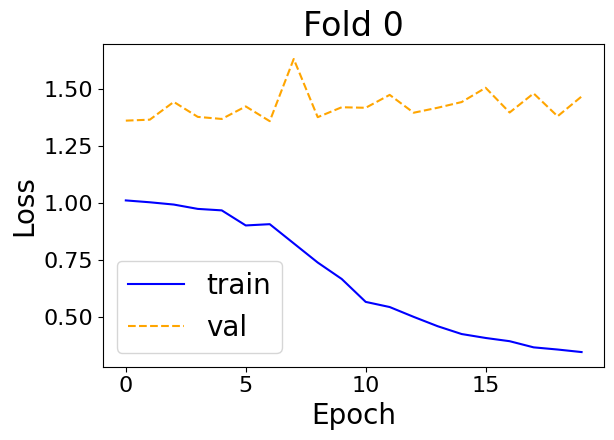

Output()

Output()

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.6023668050765991     │
│          test/r2          │    0.0965965986251831     │
│         test/rmse         │    0.7919130325317383     │
└───────────────────────────┴───────────────────────────┘

Output()

CV iteration 1


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /content/checkpoints exists and is not empty.


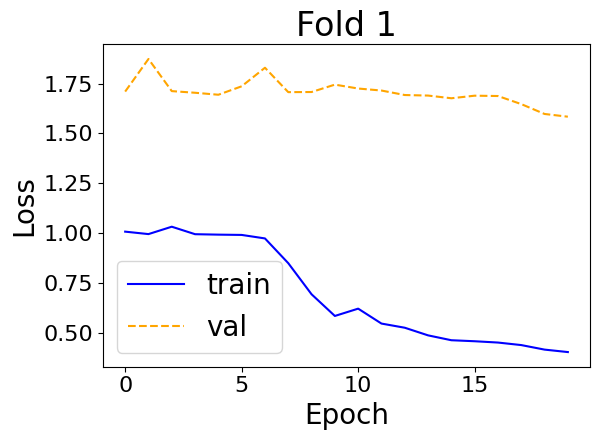

Output()

Output()

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │     0.55646812915802      │
│          test/r2          │   -0.01153111457824707    │
│         test/rmse         │    0.6604621410369873     │
└───────────────────────────┴───────────────────────────┘

Output()

CV iteration 2


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /content/checkpoints exists and is not empty.


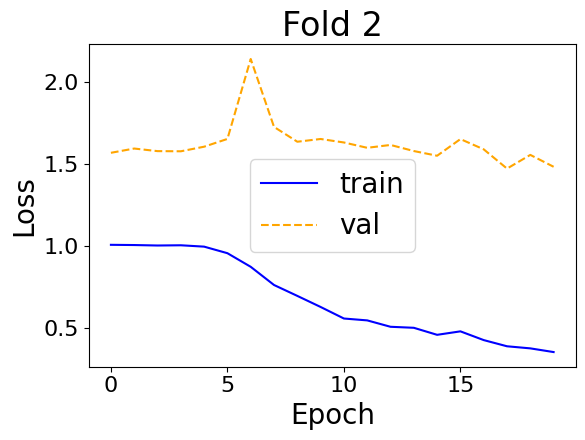

Output()

Output()

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.5755906701087952     │
│          test/r2          │    0.11986184120178223    │
│         test/rmse         │     0.741690993309021     │
└───────────────────────────┴───────────────────────────┘

Output()

CV iteration 3


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /content/checkpoints exists and is not empty.


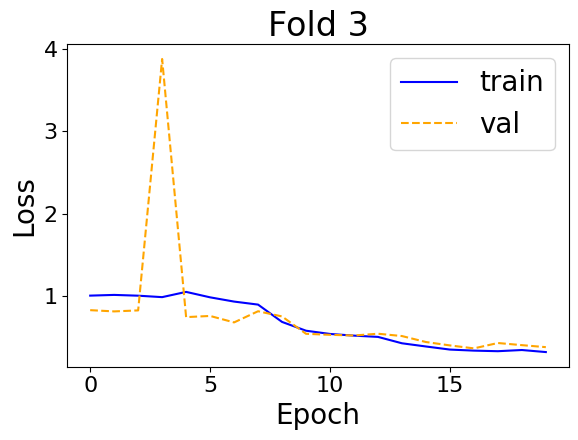

Output()

Output()

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.8118875026702881     │
│          test/r2          │   -0.41897082328796387    │
│         test/rmse         │    1.0241456031799316     │
└───────────────────────────┴───────────────────────────┘

CV iteration 4


Output()

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /content/checkpoints exists and is not empty.


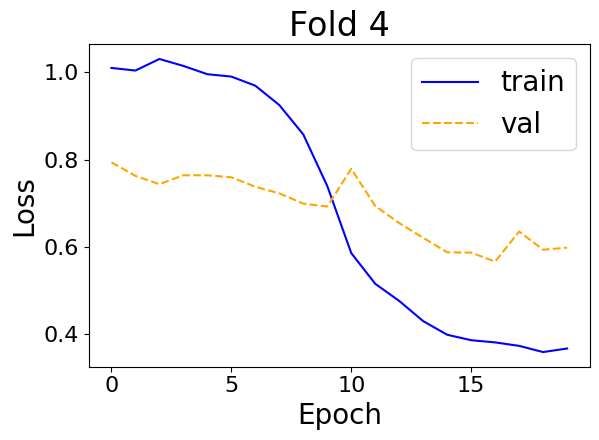

Output()

Output()

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.4706327021121979     │
│          test/r2          │    0.5572493672370911     │
│         test/rmse         │    0.5665742754936218     │
└───────────────────────────┴───────────────────────────┘

Output()

CV iteration 5


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /content/checkpoints exists and is not empty.


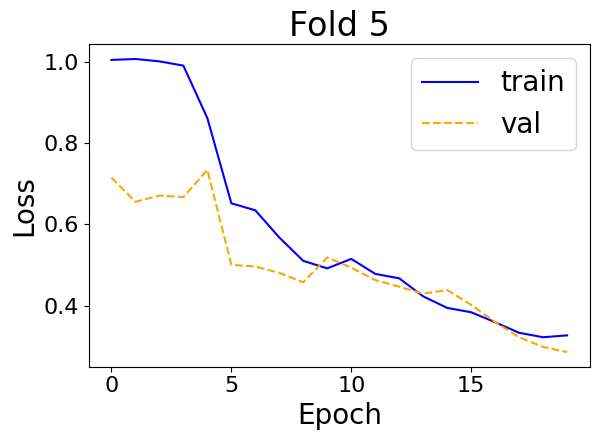

Output()

Output()

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.30713126063346863    │
│          test/r2          │    0.42549848556518555    │
│         test/rmse         │    0.42587465047836304    │
└───────────────────────────┴───────────────────────────┘

Output()

CV iteration 6


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /content/checkpoints exists and is not empty.


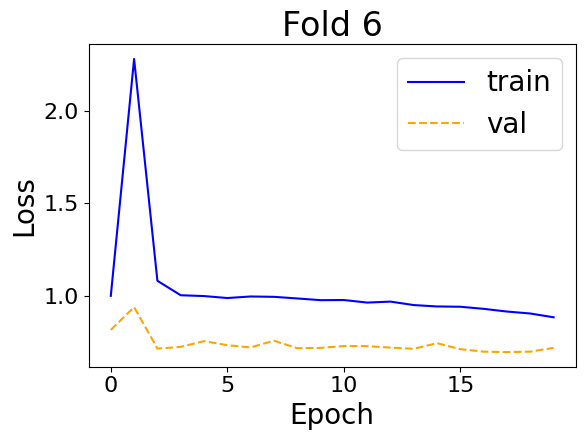

Output()

Output()

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.2750430405139923     │
│          test/r2          │    0.9015491008758545     │
│         test/rmse         │    0.37637487053871155    │
└───────────────────────────┴───────────────────────────┘

Output()

CV iteration 7


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /content/checkpoints exists and is not empty.


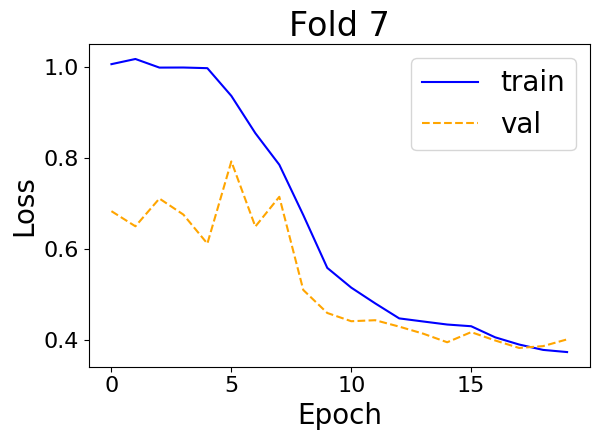

Output()

Output()

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.4767669141292572     │
│          test/r2          │    0.5508477687835693     │
│         test/rmse         │    0.6111487150192261     │
└───────────────────────────┴───────────────────────────┘

Output()

CV iteration 8


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /content/checkpoints exists and is not empty.


Output()

Output()

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.4020940959453583     │
│          test/r2          │    0.4603983163833618     │
│         test/rmse         │     0.504618227481842     │
└───────────────────────────┴───────────────────────────┘

CV iteration 9


Output()

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /content/checkpoints exists and is not empty.


Output()

Output()

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.4207674264907837     │
│          test/r2          │    0.4707528352737427     │
│         test/rmse         │    0.49920204281806946    │
└───────────────────────────┴───────────────────────────┘

Total training time: 825.31 seconds (13.76 minutes)
{'MAE': 0.5641373826866878, 'RMSE': np.float64(0.7632198213553992), 'Ratio': np.float64(1.3528970863809577), 'R² Score': 0.1626685046441052}


In [ ]:
y_data_scaff_B_2, y_predictions_scaff_B_2 = cross_validation_chemeleon_no_pre_training(all_data, indices_scaff_B_2)

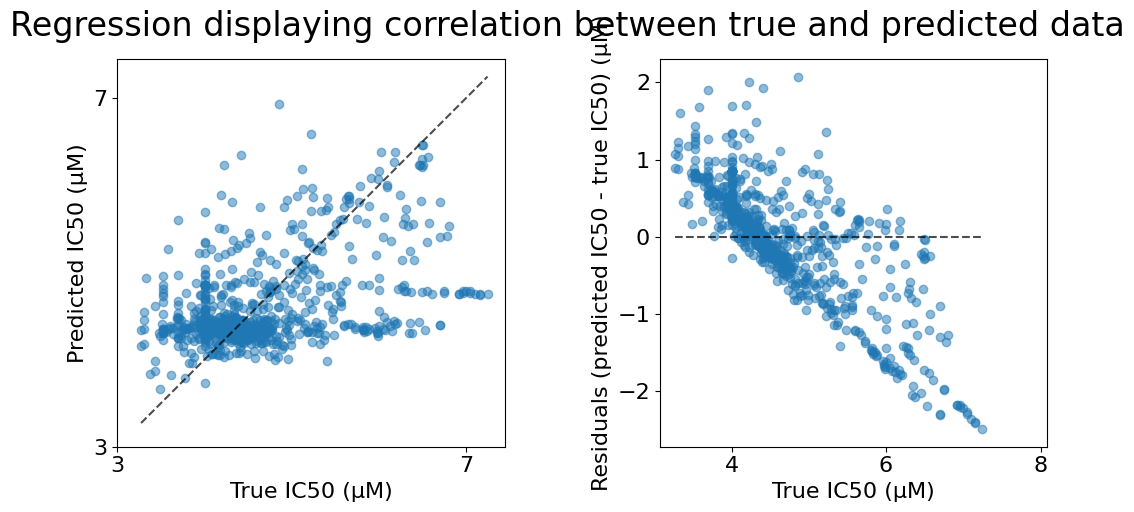

In [ ]:
plot_cv_results(y_data_scaff_B_2, y_predictions_scaff_B_2)